
# A template for analysing the data in python

This template is made to provide basic python commands for the reading and small processing of the data. Use it with care and try to adapt it to the spectra that you have taken during the lab. 

Implements:
-  file reading
-  simple peak finder that you will need to adapt maybe for each source
-  selection of a region around a peak

You will need to implement
-  the uncertainties on the y variable 
-  a fit of the data with a Gaus function
-  a linear fit to perform the energy calibration
-  determine the energy resolution dependence 
-  ...

Where to find information: internet is amazing for python


In [1]:
from IPython.display import HTML, display
from textwrap import dedent

def code_hider():
    """Creates a button to toggle visibility of all code cells in a Jupyter notebook."""
    display(HTML(dedent('''
        <script>
        var code_show = true;
        function code_toggle() {
            if (code_show){
                $('div.input').hide();
            } else {
                $('div.input').show();
            }
            code_show = !code_show;
        }
        </script>
        <form action="javascript:code_toggle()">
            <input type="submit" value="Show/hide all code in this notebook">
        </form>
    ''')))

# Call it to display the button
code_hider()


In [2]:
# Boilerplate startup code
%matplotlib notebook
%matplotlib inline
import math
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import codecs
from datetime import datetime
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import linregress

matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (15.0, 10.0)    # resize plots


def read_file(file):
    ''' a simple function to read the files and produce a pandas DataFrame '''
    #    arguments: file = the file you want to read
    #      returns: df = pandas DataFrame
    
    COMMENT_CHAR = '#'
    columns = []
    with file as td:
        for line in td:
            # find the commented lines
            if line[0] == COMMENT_CHAR or line[0] =='t' :
                if ('t=') in line:
                    splitvalues= line.split(" ")
                    time = float(splitvalues[0][2:-2])
                    
            # when we see the first line that doesn't start with 
            # COMMENT_CHAR, we pass the remaining lines of the 
            # file to pandas.read_table and break our loop
            else:
                _dfs = [
                        pd.DataFrame([line.split()]),
                        pd.read_table(td, sep='\s+', names=['channel', 'N'], header=None, engine='python')
                        ]
                df = pd.concat(_dfs, ignore_index=True)
    
    df['NEr'] = [math.sqrt(y)/time for y in df.N]
    df['nu'] = df.N/time
    #remove rows if at least 3 values in a row are NaN
    df = df.dropna(thresh=3)
    # drop the 2 first columns
    df = df.drop([0,1], axis = 1)
    return df

def detect_peaks(data, max_channel, min_height, min_distance, min_prominence, min_width, plot=True, use_log=False):
    """
    Detects peaks in a spectrum and optionally plots the result.

    Parameters:
        data (pd.DataFrame): DataFrame with 'channel' and 'N' columns.
        max_channel (int): Upper limit for channel range to search for peaks.
        min_height (float): Minimum height for peak detection.
        min_distance (int): Minimum number of channels between peaks.
        min_prominence (float): Minimum prominence of peaks.
        min_width (int): Minimum width of peaks.
        plot (bool): Whether to display the plot.
        use_log (bool): Whether to analyze log(N) instead of raw counts.

    Returns:
        peak_df (pd.DataFrame): DataFrame with detected peak information.
    """
    # Filter data
    data_range = data.loc[data.channel < max_channel].copy()

    # Handle log transformation if requested
    if use_log:
        # Replace zero or negative values to avoid log(0)
        data_range['N_transformed'] = np.log(data_range['N'].replace(0, np.nan)).fillna(0)
    else:
        data_range['N_transformed'] = data_range['N']

    # Find peaks
    peaks, properties = signal.find_peaks(
        data_range['N_transformed'],
        height=min_height,
        distance=min_distance,
        prominence=min_prominence,
        width=min_width
    )

    # Extract peak data
    peak_channels = data_range.channel.iloc[peaks]
    peak_counts = data_range.N.iloc[peaks]  # Always report actual (raw) counts

    # Create DataFrame with peak info
    peak_df = pd.DataFrame({
        'Peak_Number': range(1, len(peak_channels) + 1),
        'Channel': peak_channels.values,
        'Counts': peak_counts.values,
        'FWHM': properties['widths'],
        'Prominence': properties['prominences']
    })

    # Optional plot
    if plot:
        fig, ax = plt.subplots(figsize=(12, 8))
        y_label = "log(Counts)" if use_log else "Counts"

        ax.plot(data_range.channel, data_range['N_transformed'], 'b-', alpha=0.7, linewidth=1.5, label="Spectrum")
        ax.plot(peak_channels, data_range['N_transformed'].iloc[peaks], 'ro', markersize=8, label="Detected Peaks")

        for i, (ch, ct) in enumerate(zip(peak_channels, data_range['N_transformed'].iloc[peaks])):
            ax.annotate(f"Peak {i+1}\nCh: {ch:.1f}",
                        xy=(ch, ct),
                        xytext=(10, 10),
                        textcoords='offset points',
                        fontsize=9,
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='gray'))

        # Legend and peak info box
        ax.legend(loc='upper right', fontsize=12)

        peak_info = "\n".join([f"Peak {i+1}: Ch = {ch:.1f}, Cts = {ct:.1f}" 
                               for i, (ch, ct) in enumerate(zip(peak_channels, peak_counts))])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.99, 0.87, peak_info, transform=ax.transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=props)

        ax.set_title("Peak Detection in Spectrum", fontsize=14)
        ax.set_xlabel("Channel", fontsize=12)
        ax.set_ylabel(y_label, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    print("Detected Peaks:")
    print(peak_df)

    return peak_df


def select_region(data, peak_value, nr_of_channels, use_log=False):
    """
    Select a region of the spectrum around a peak value.

    Parameters:
        data (pd.DataFrame): DataFrame with 'channel' and 'N' columns.
        peak_value (float): Center channel of the region.
        nr_of_channels (int): Number of channels to include on each side.
        use_log (bool): If True, adds a column 'N_transformed' with log(N).

    Returns:
        pd.DataFrame: Filtered DataFrame with optional 'N_transformed' column.
    """
    region = data[(data.channel >= peak_value - nr_of_channels) &
                  (data.channel <= peak_value + nr_of_channels)].copy()

    if use_log:
        # Avoid log(0) and log of negative numbers
        region['N_transformed'] = np.log(region['N'].replace(0, np.nan)).fillna(0)
    else:
        region['N_transformed'] = region['N']

    return region

def gaus(x, a, x0, sigma):
    """
    Gaussian function for curve fitting.
    
    Parameters:
    -----------
    x : array-like
        The x values
    a : float
        The amplitude of the Gaussian
    x0 : float
        The mean (center) of the Gaussian
    sigma : float
        The standard deviation of the Gaussian
        
    Returns:
    --------
    array-like
        The y values of the Gaussian function
    """
    # Prevent negative sigma which would cause mathematical errors
    if sigma <= 0:
        return np.ones_like(x) * float('inf')  # Better error handling
    
    # Full Gaussian formula
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def parabola(x, a, b, c):
    return a * x**2 + b * x + c

def fit_the_peak(selected, energy, height_guess=None, peak_guess=None, width_guess=None, 
                 title="Gaussian Peak Fit", do_the_plot=True, use_log=False):
    """
    Fit a Gaussian (raw) or quadratic (log) to a peak in spectral data.
    """
    x = selected.channel.values

    if use_log:
        y = selected['N_transformed'].values
        y_err = np.ones_like(y)  # constant error for log fit
        y_label = 'log(Number of events)'
    else:
        y = selected.N.values
        y_err = selected.NEr.values
        y_label = 'Number of events'

    # Default initial guesses
    if height_guess is None:
        height_guess = np.max(y)
    if peak_guess is None:
        peak_guess = x[np.argmax(y)]
    if width_guess is None:
        width_guess = (np.max(x) - np.min(x)) / 10

    try:
        if use_log:
            # Fit quadratic (parabola) to log data
            popt, pcov = curve_fit(parabola, x, y, sigma=y_err, absolute_sigma=True)
            a, b, c = popt
            mu = -b / (2 * a)
            sigma = np.sqrt(-1 / (2 * a)) if a < 0 else np.nan
            perr = np.sqrt(np.diag(pcov))

            result = {
                'mean': float(mu),
                'mean_er': np.nan,
                'sigma': float(sigma),
                'sigma_er': np.nan,
                'a': a, 'b': b, 'c': c,
                'energy': energy if energy != 0 else 'unknown',
                'fit_type': 'log-parabola'
            }

            if do_the_plot:
                plt.figure(figsize=(10, 6))
                plt.plot(x, y, 'bo-', label='Log data')
                x_fit = np.linspace(np.min(x), np.max(x), 1000)
                y_fit = parabola(x_fit, *popt)
                plt.plot(x_fit, y_fit, 'r-', linewidth=2,
                         label=f'Quadratic fit\nμ = {mu:.2f}, σ = {sigma:.2f}' if a < 0 else 'Fit failed (a > 0)')
                plt.legend(fontsize=12)
                plt.title(title + " (log fit)", fontsize=14)
                plt.xlabel('ADC Channel', fontsize=12)
                plt.ylabel(y_label, fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

        else:
            # Fit Gaussian to raw data
            popt, pcov = curve_fit(
                gaus, x, y, sigma=y_err,
                p0=[height_guess, peak_guess, width_guess],
                absolute_sigma=True
            )
            perr = np.sqrt(np.diag(pcov))

            result = {
                'mean': float(popt[1]), 
                'mean_er': perr[1],
                'sigma': float(popt[2]), 
                'sigma_er': perr[2],
                'amplitude': float(popt[0]),
                'amplitude_er': perr[0],
                'energy': energy if energy != 0 else 'unknown',
                'fit_type': 'gaussian'
            }

            if do_the_plot:
                plt.figure(figsize=(10, 6))
                plt.errorbar(x, y, yerr=y_err, fmt='o-', markersize=4,
                             label='Data', alpha=0.7, elinewidth=1)
                x_fit = np.linspace(np.min(x), np.max(x), 1000)
                plt.plot(x_fit, gaus(x_fit, *popt), 'r-', linewidth=2,
                         label=f'Gaussian fit\nμ = {popt[1]:.2f} ± {perr[1]:.2f}\nσ = {popt[2]:.2f} ± {perr[2]:.2f}')
                plt.legend(fontsize=12)
                plt.title(title, fontsize=14)
                plt.xlabel('ADC Channel', fontsize=12)
                plt.ylabel(y_label, fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

        return result

    except RuntimeError as e:
        print(f"Error in curve fitting: {e}")
        return None



def analyze_spectrum_peaks(data, peakLoc, peak_df, peaks_energies,peaks=None, widths=None, verbose=True, use_log=False):
    """
    Full pipeline to analyze and fit detected peaks in a spectrum.

    Parameters:
        data (pd.DataFrame): Full spectrum with 'channel' and 'N' columns.
        peakLoc (array-like): List or array of peak channel positions.
        peak_df (pd.DataFrame): Peak info containing Prominence and FWHM.
        peaks_energies (list): Known energies corresponding to each peak.
        widths (list or None): Peak widths. If None, uses FWHM from peak_df.
        verbose (bool): If True, print fit results.
        use_log (bool): If True, use log-transformed counts for fitting.

    Returns:
        means (list): Fitted peak means.
        mean_errors (list): Errors on means.
        sigmas (list): Fitted sigmas.
        sigma_errors (list): Errors on sigmas.
    """
    num_peaks = len(peakLoc)

    # Prepare peaks and widths
    peaks = [float(peakLoc[i]) for i in range(num_peaks)]
    if widths is None:
        widths = [float(peak_df.FWHM.iloc[i]) for i in range(num_peaks)]

    # Select region around each peak
    selected_data_list = []
    for i, (peak, width) in enumerate(zip(peaks, widths)):
        selected = select_region(data, peak, width, use_log=use_log)
        selected_data_list.append(selected)

    # Label for display
    peak_labels = [f"Peak {i+1} Analysis" for i in range(num_peaks)] 

    # Fit results
    means, mean_errors, sigmas, sigma_errors = [], [], [], []

    for i in range(num_peaks):
        raw_height_guess = float(peak_df.Prominence.iloc[i])
        log_height_guess = np.log(raw_height_guess) if raw_height_guess > 0 else 0

        result = fit_the_peak(
            selected=selected_data_list[i],
            energy=peaks_energies[i],
            height_guess=log_height_guess if use_log else raw_height_guess,
            peak_guess=peaks[i],
            width_guess=widths[i],
            title=peak_labels[i], 
            use_log=use_log
        )

        if verbose:
            print(f"\n--- Results for {peak_labels[i]} ---")
            for key, value in result.items():
                print(f"{key}: {value}")

        means.append(result['mean'])
        mean_errors.append(result['mean_er'])
        sigmas.append(result['sigma'])
        sigma_errors.append(result['sigma_er'])

    return means, mean_errors, sigmas, sigma_errors

## Césium 137

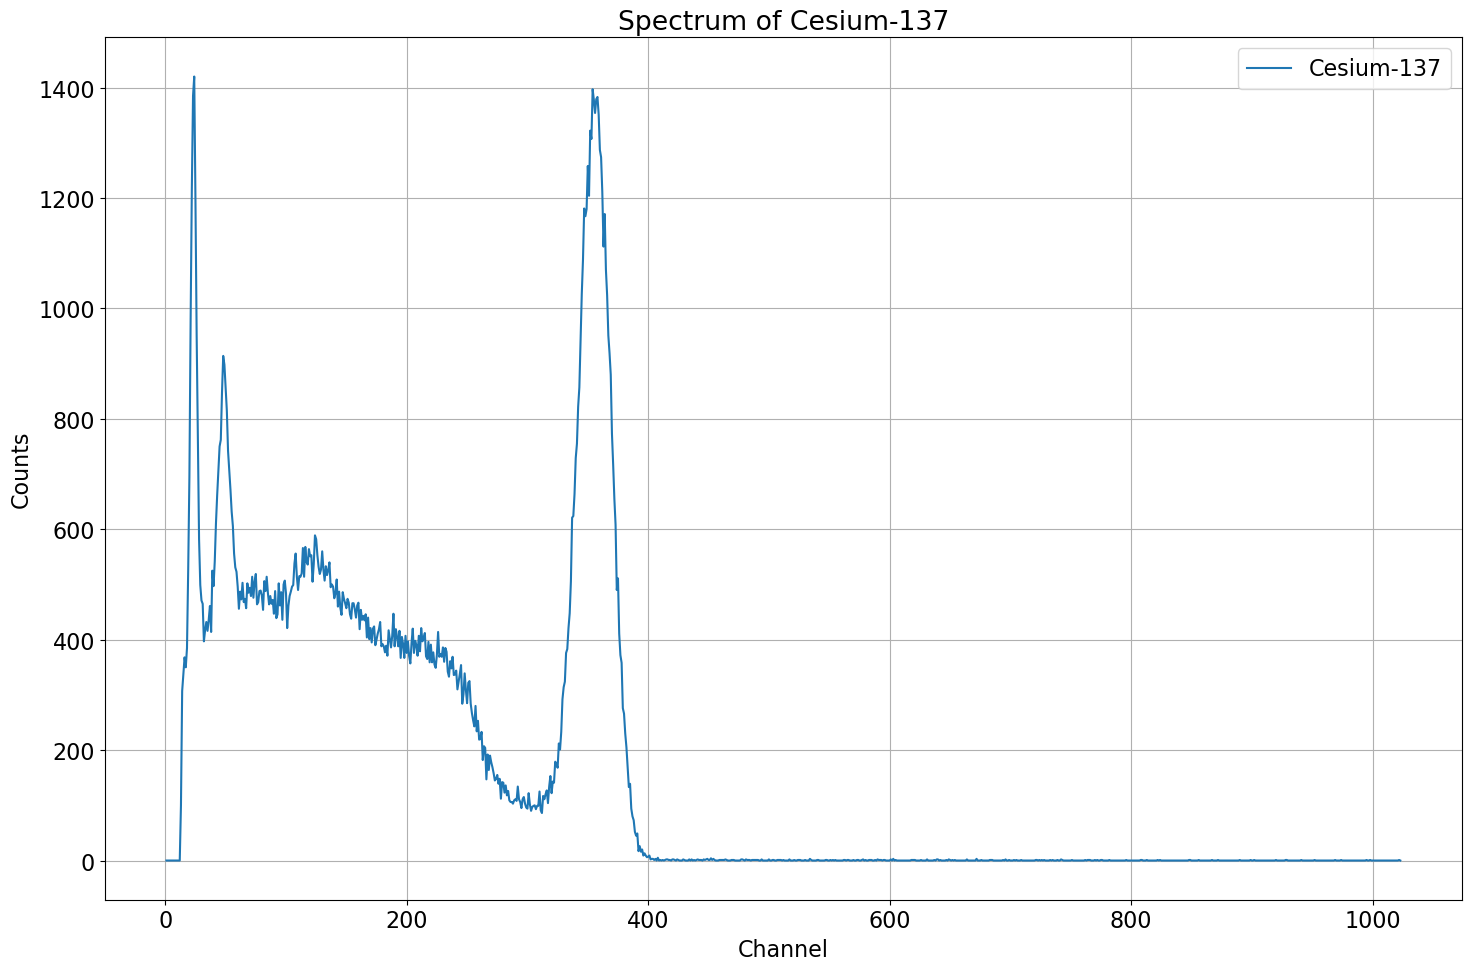

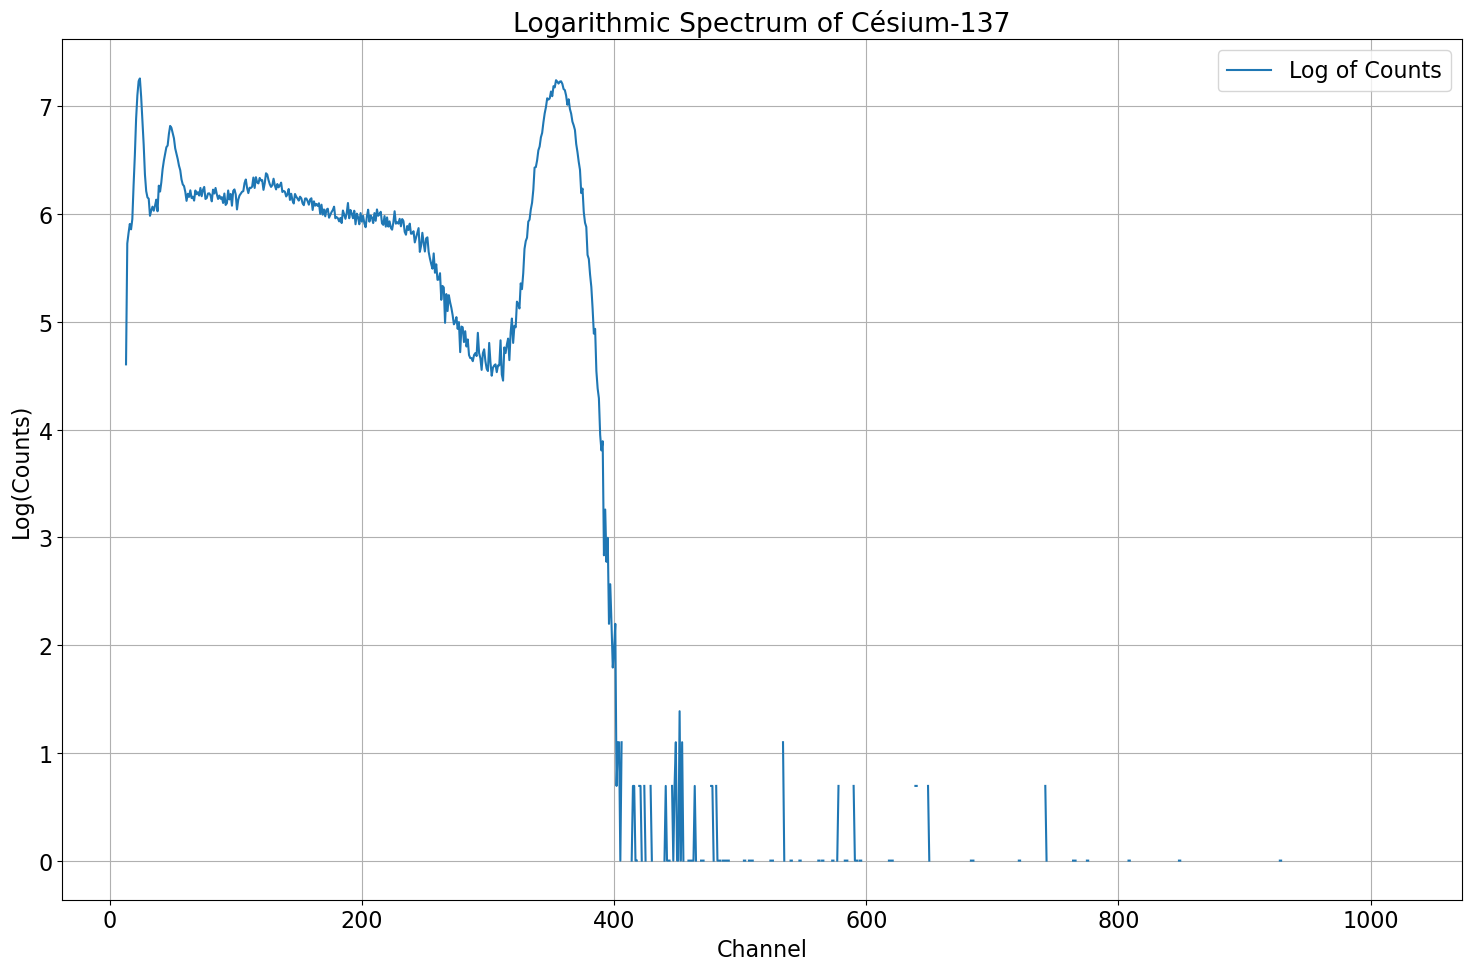

In [3]:
# File path
filename = '/home/dbaconsult/Downloads/PHYSF210/PTM/Detecteur1/Césium137.txt'

# Read the file
fileCs = codecs.open(filename, encoding = "ISO-8859-1")
data = read_file(fileCs)

# Plot: raw data
plt.figure()
plt.plot(data['channel'], data['N'], label="Cesium-137")
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.title("Spectrum of Cesium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: log-transformed data
plt.figure()
plt.plot(data['channel'], np.log(data['N'].replace(0, np.nan)), label="Log of Counts")  # Avoid log(0)
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Log(Counts)")
plt.title("Logarithmic Spectrum of Césium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

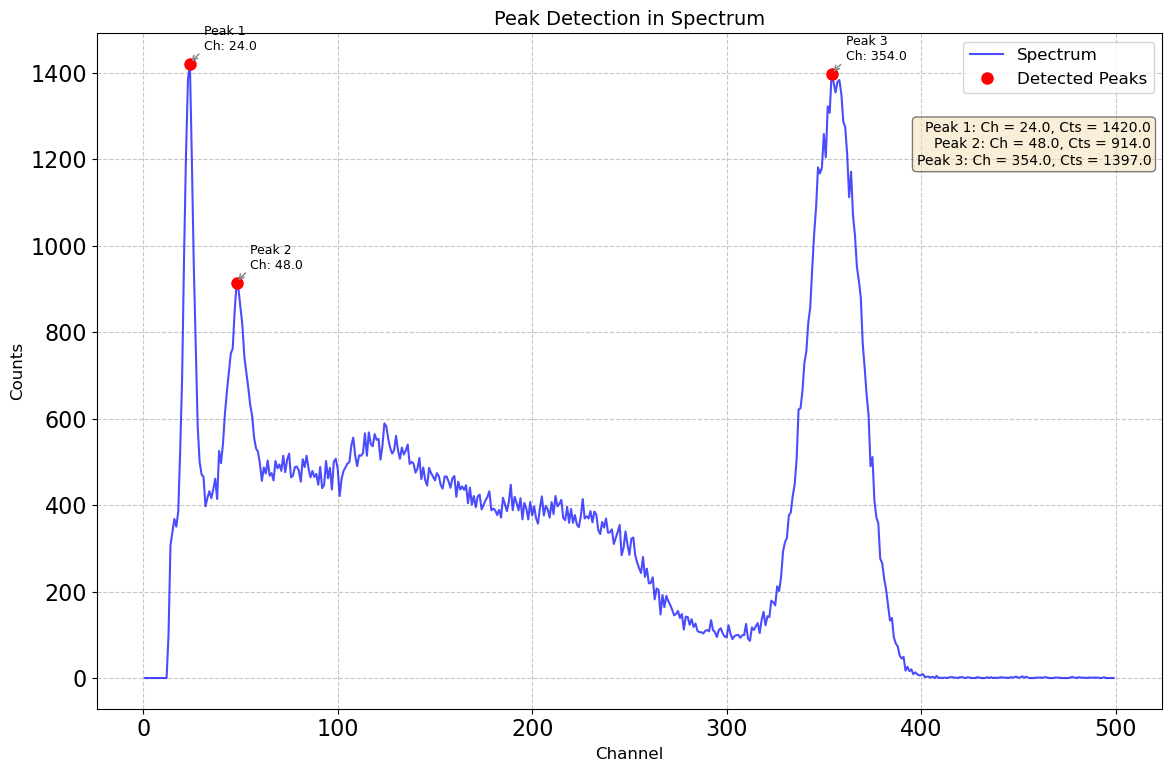

Detected Peaks:
   Peak_Number  Channel  Counts       FWHM  Prominence
0            1     24.0  1420.0   7.265686      1420.0
1            2     48.0   914.0  11.539951       517.0
2            3    354.0  1397.0  30.081731      1311.0


In [4]:
# Peak locations
peak_df =  detect_peaks(data, max_channel=500, min_height=500, min_distance=5, min_prominence=500, min_width=5, plot=True)
peakLoc= peak_df['Channel']

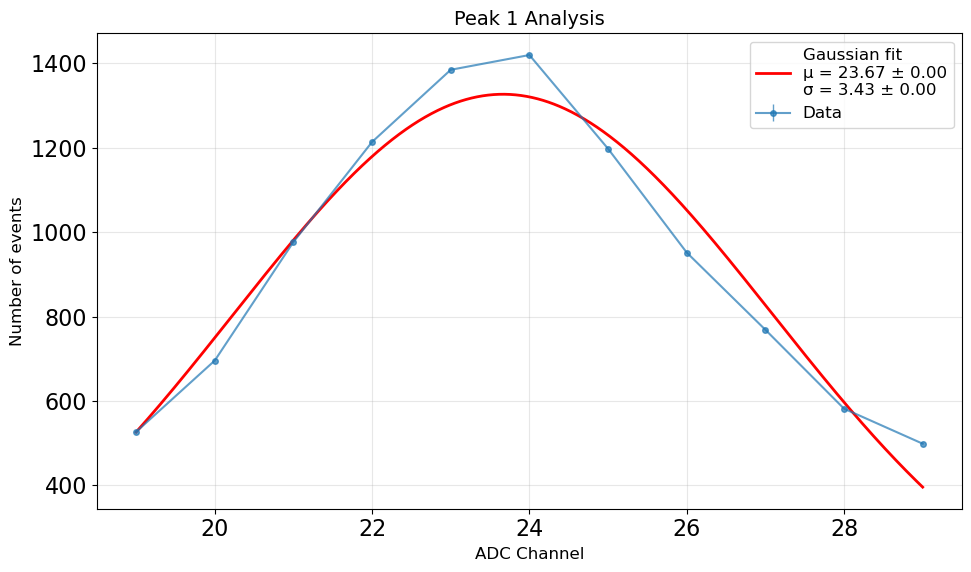


--- Results for Peak 1 Analysis ---
mean: 23.66510408698698
mean_er: 0.00021423425506200938
sigma: 3.43078055461834
sigma_er: 0.0002630296630992356
amplitude: 1327.043037198581
amplitude_er: 0.08839552680020568
energy: unknown
fit_type: gaussian


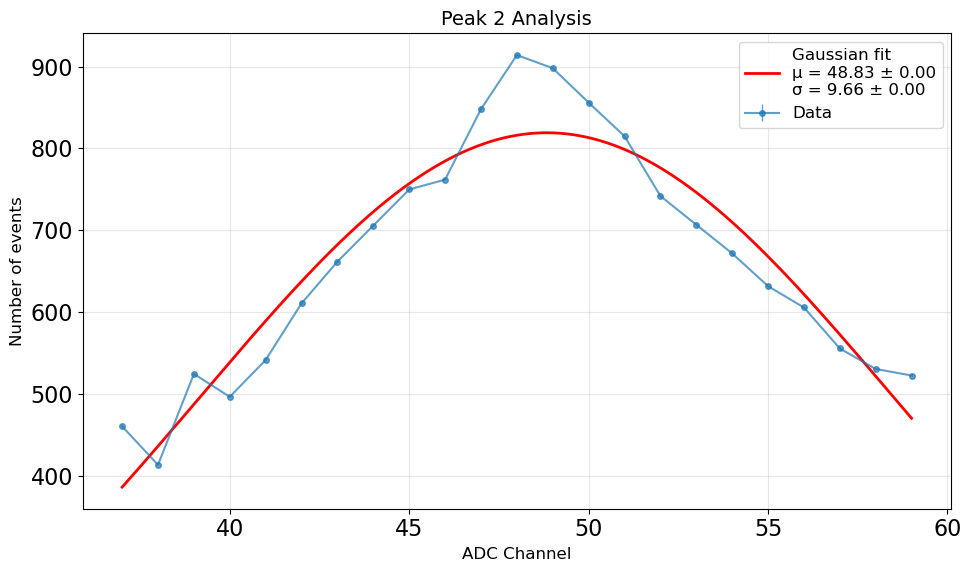


--- Results for Peak 2 Analysis ---
mean: 48.833262730019236
mean_er: 0.0006259621954548915
sigma: 9.659913849624447
sigma_er: 0.0010044665592246432
amplitude: 819.2098372338486
amplitude_er: 0.04606607535921646
energy: unknown
fit_type: gaussian


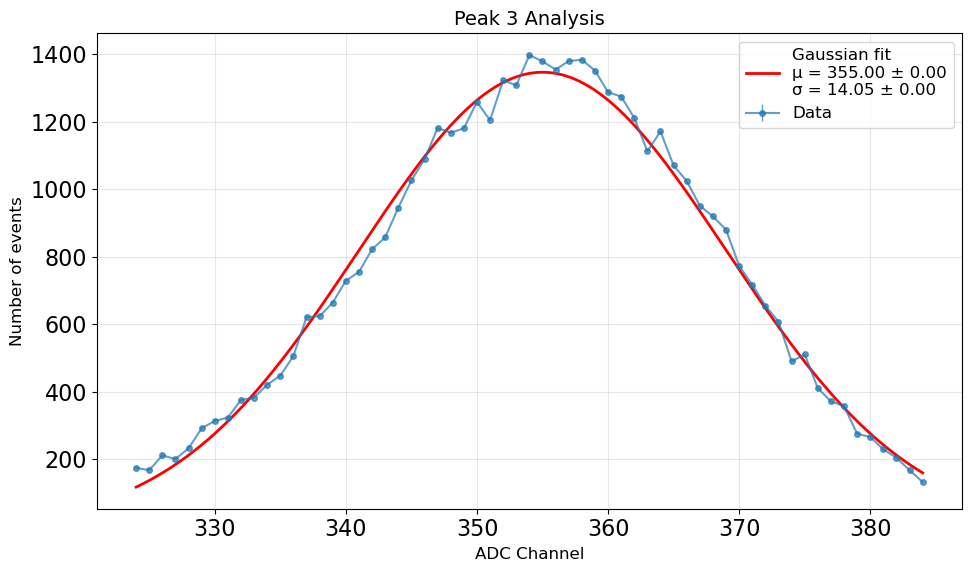


--- Results for Peak 3 Analysis ---
mean: 355.0039052101494
mean_er: 0.00034925089976057746
sigma: 14.051621907875635
sigma_er: 0.00032144431362690965
amplitude: 1345.972127137057
amplitude_er: 0.03977263483651255
energy: 661.657
fit_type: gaussian


In [5]:
#Peak analysis
peaks_energies_Cs=[0,0,661.657] #theoretical energy (in keV) of the peaks. 0 means unkown
widths = [float(peak_df.FWHM.iloc[0])-2,float(peak_df.FWHM.iloc[1]),float(peak_df.FWHM.iloc[2])]
meansCs, mean_errsCs, sigmasCs, sigma_errsCs = analyze_spectrum_peaks(
    data=data,
    peakLoc=peakLoc,
    peak_df=peak_df,peaks_energies=peaks_energies_Cs,widths=widths)


## Barium 133

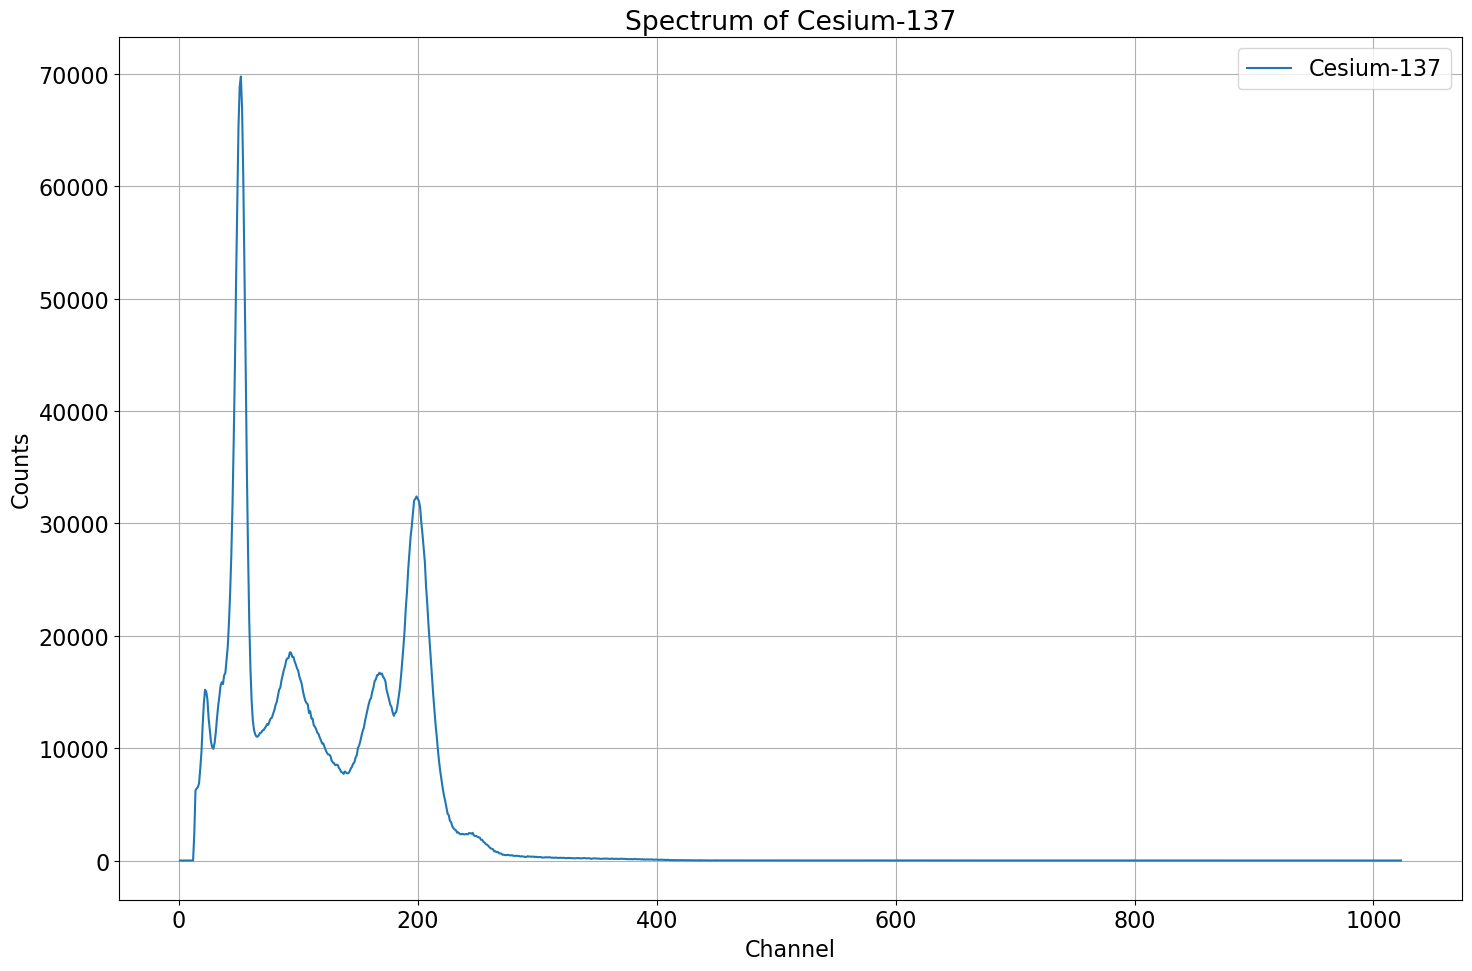

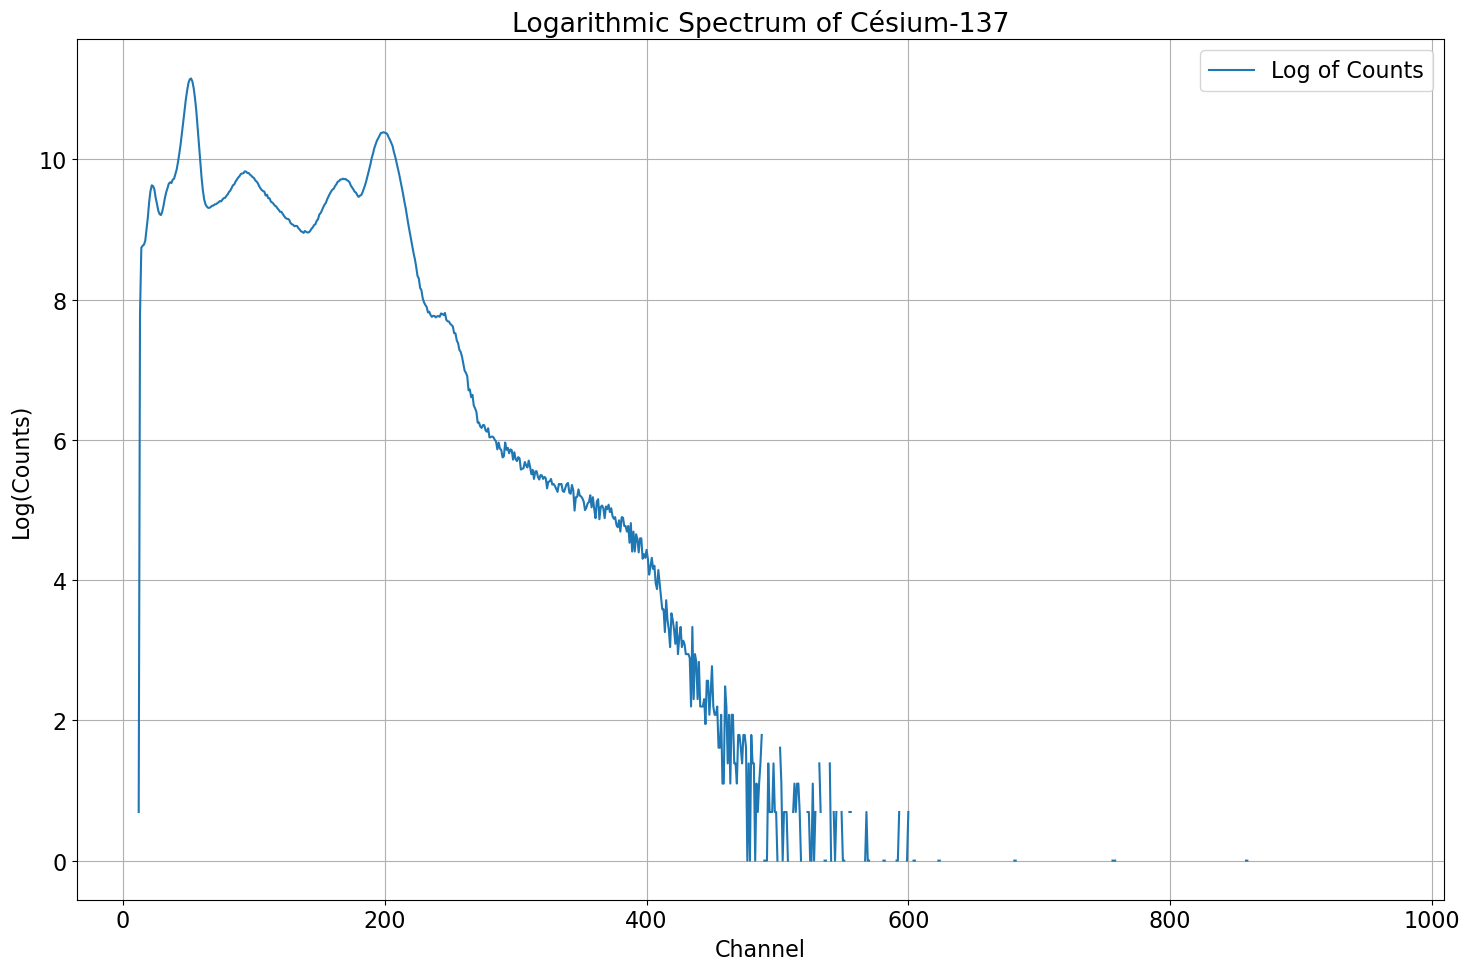

In [6]:
# File path
filename = '/home/dbaconsult/Downloads/PHYSF210/PTM/Detecteur1/Barium133.txt'

# Read the file
fileBa = codecs.open(filename, encoding = "ISO-8859-1")
data = read_file(fileBa)

# Plot: raw data
plt.figure()
plt.plot(data['channel'], data['N'], label="Cesium-137")
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.title("Spectrum of Cesium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: log-transformed data
plt.figure()
plt.plot(data['channel'], np.log(data['N'].replace(0, np.nan)), label="Log of Counts")  # Avoid log(0)
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Log(Counts)")
plt.title("Logarithmic Spectrum of Césium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

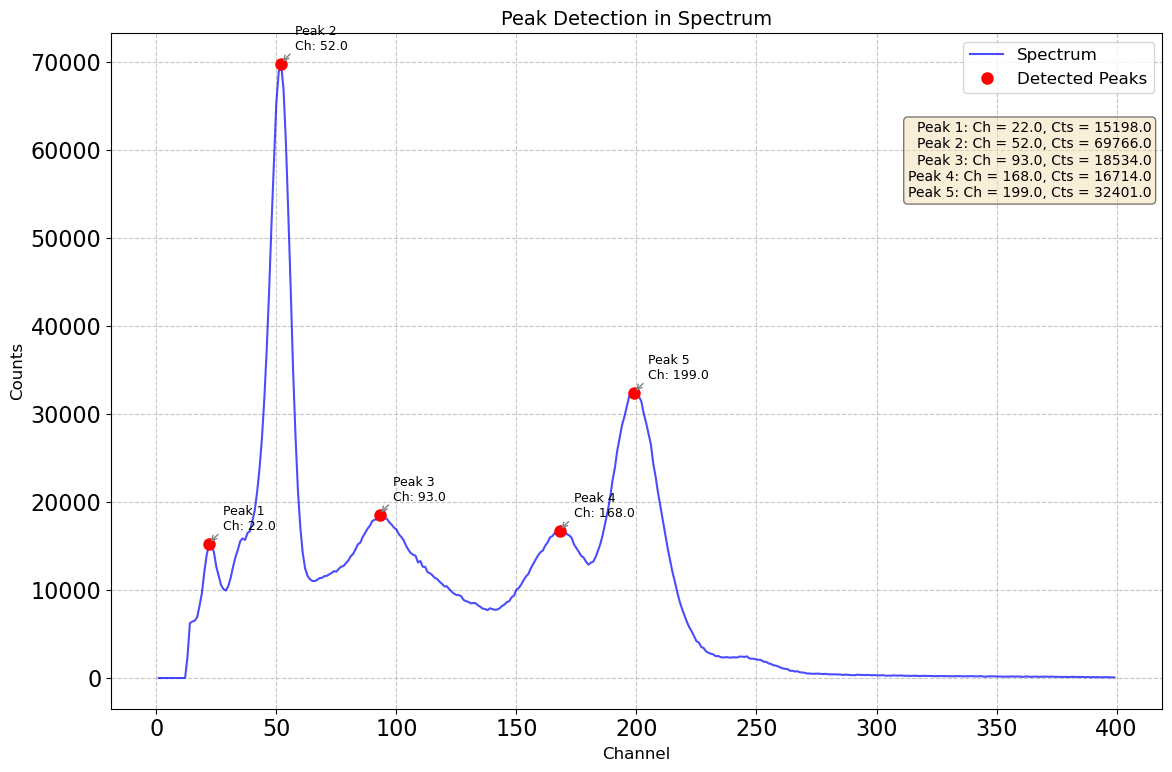

Detected Peaks:
   Peak_Number  Channel   Counts       FWHM  Prominence
0            1     22.0  15198.0   4.806101      5254.0
1            2     52.0  69766.0  11.422211     69692.0
2            3     93.0  18534.0  21.322096      7517.0
3            4    168.0  16714.0  13.338615      3836.0
4            5    199.0  32401.0  20.866514     24689.0


In [7]:
# Peak locations
peak_df =  detect_peaks(data, max_channel=400, min_height=500, min_distance=4, min_prominence=500, min_width=4, plot=True)
peakLoc= peak_df['Channel']

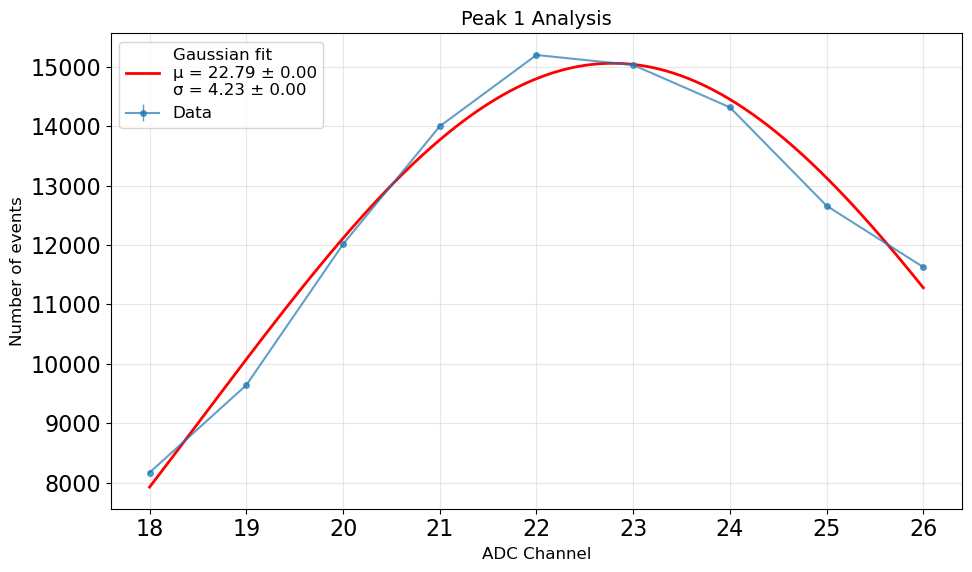


--- Results for Peak 1 Analysis ---
mean: 22.78783870211855
mean_er: 0.00021041549020386617
sigma: 4.2262968712012885
sigma_er: 0.0003345118561520904
amplitude: 15058.60675840378
amplitude_er: 0.5146512961440484
energy: unknown
fit_type: gaussian


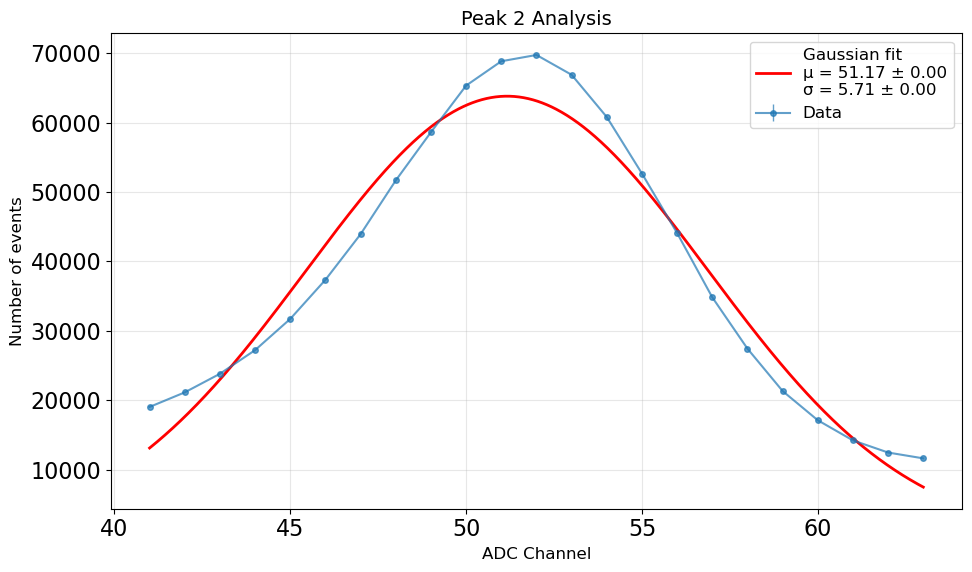


--- Results for Peak 2 Analysis ---
mean: 51.16586802034255
mean_er: 5.7447308057169435e-05
sigma: 5.713243061819962
sigma_er: 5.8202890905466055e-05
amplitude: 63822.639948656724
amplitude_er: 0.7494597819326703
energy: 81.0
fit_type: gaussian


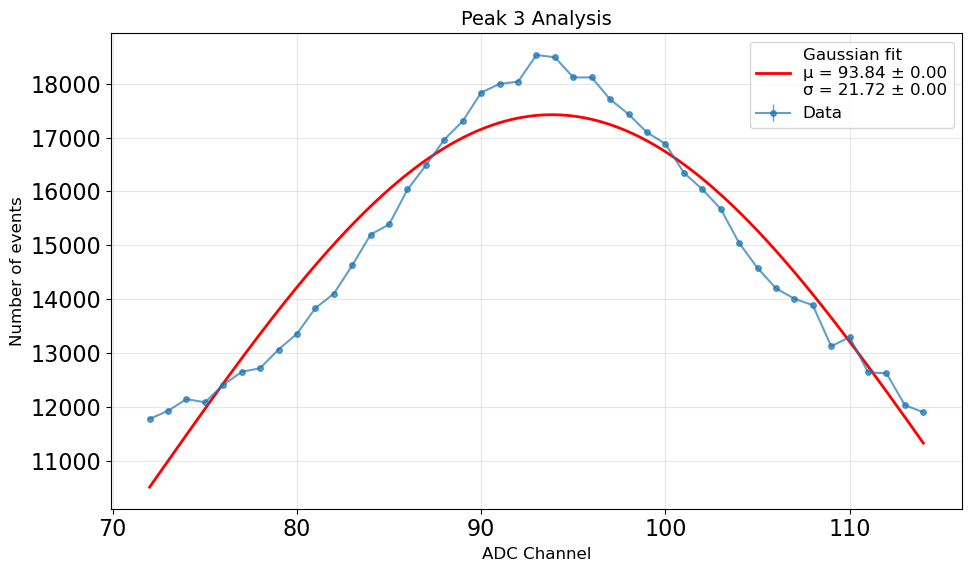


--- Results for Peak 3 Analysis ---
mean: 93.84112877318383
mean_er: 0.0004160689335716309
sigma: 21.722181892262867
sigma_er: 0.000811780760615922
amplitude: 17425.22897769244
amplitude_er: 0.25668051394420194
energy: unknown
fit_type: gaussian


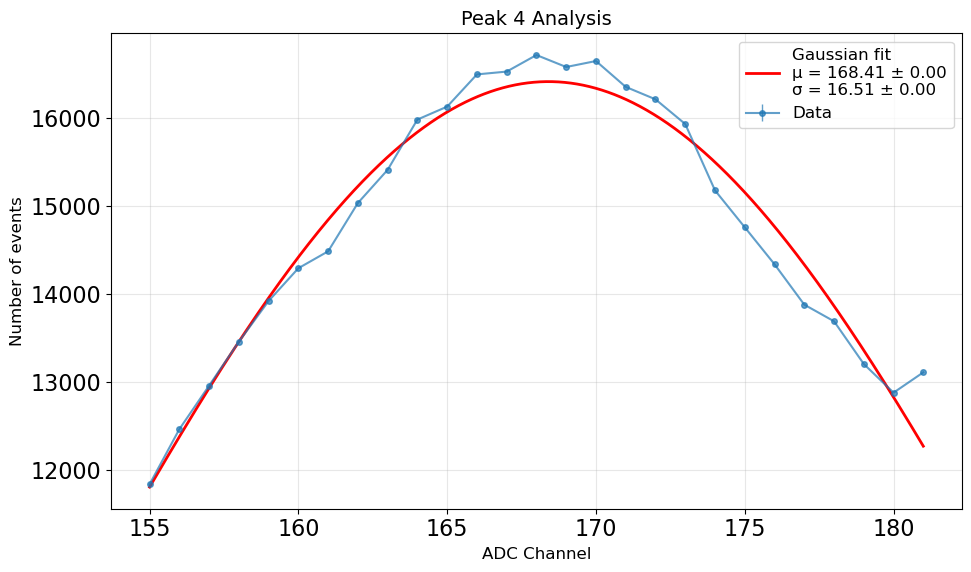


--- Results for Peak 4 Analysis ---
mean: 168.40527804757173
mean_er: 0.00047570526611918353
sigma: 16.513352275212952
sigma_er: 0.0011186373140912743
amplitude: 16412.12247194013
amplitude_er: 0.3096293424728548
energy: unknown
fit_type: gaussian


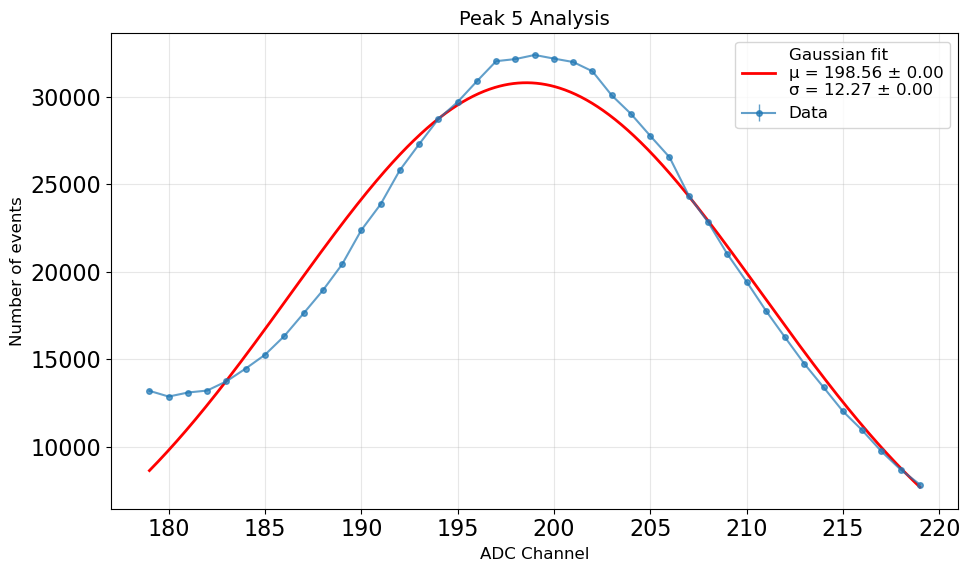


--- Results for Peak 5 Analysis ---
mean: 198.56424466344862
mean_er: 0.00013618723911281266
sigma: 12.272492223191652
sigma_er: 0.00016007424928446868
amplitude: 30813.818140231215
amplitude_er: 0.37211109294671646
energy: 356.02
fit_type: gaussian


In [8]:
#Peak analysis
peaks_energies_Ba=[0,81.0,0,0,356.02]
# widths = [float(peak_df.FWHM.iloc[0])-2,float(peak_df.FWHM.iloc[1]),float(peak_df.FWHM.iloc[2])]
meansBa, mean_errsBa, sigmasBa, sigma_errsBa = analyze_spectrum_peaks(
    data=data,
    peakLoc=peakLoc,
    peak_df=peak_df,peaks_energies=peaks_energies_Ba)


## Cobalt 60

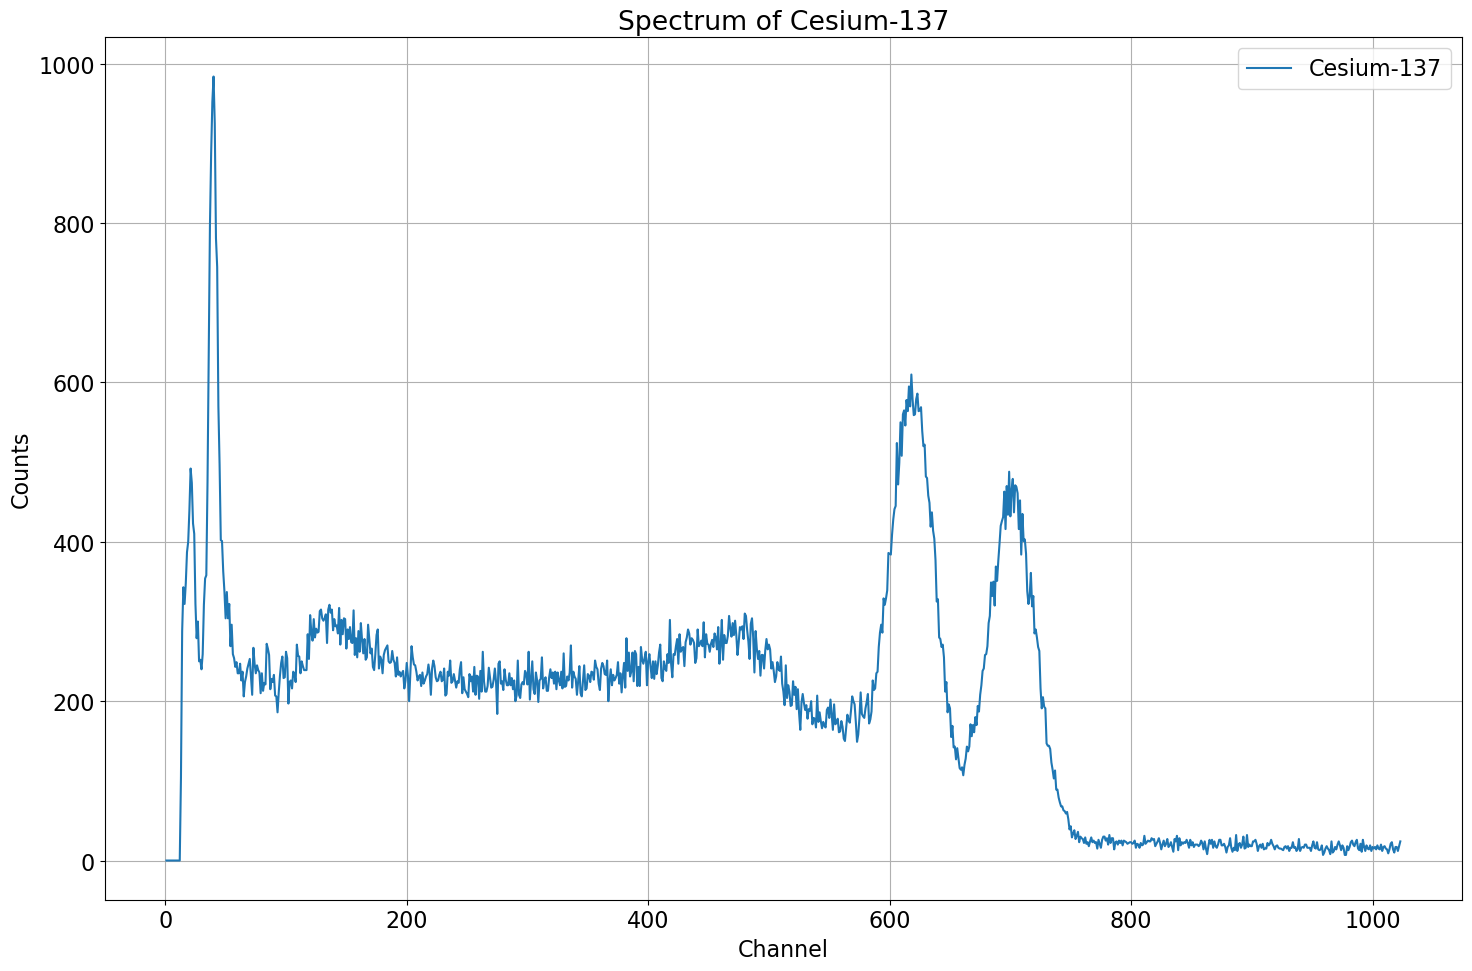

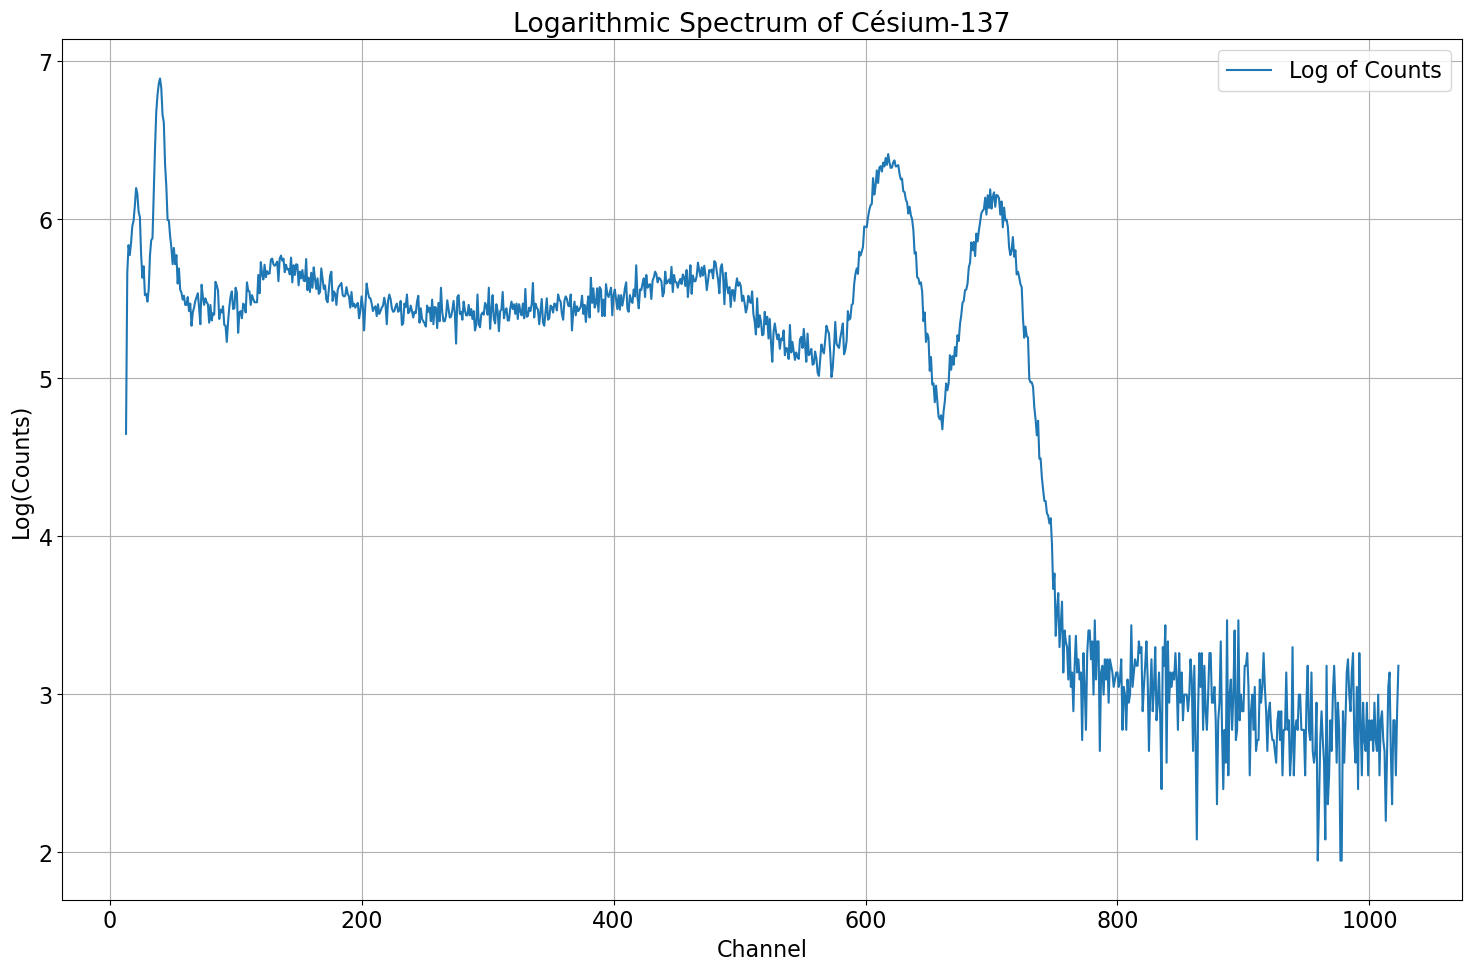

In [9]:
# File path
filename = '/home/dbaconsult/Downloads/PHYSF210/PTM/Detecteur1/Cobalt60.txt'

# Read the file
fileCo = codecs.open(filename, encoding = "ISO-8859-1")
data = read_file(fileCo)

# Plot: raw data
plt.figure()
plt.plot(data['channel'], data['N'], label="Cesium-137")
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.title("Spectrum of Cesium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: log-transformed data
plt.figure()
plt.plot(data['channel'], np.log(data['N'].replace(0, np.nan)), label="Log of Counts")  # Avoid log(0)
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Log(Counts)")
plt.title("Logarithmic Spectrum of Césium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

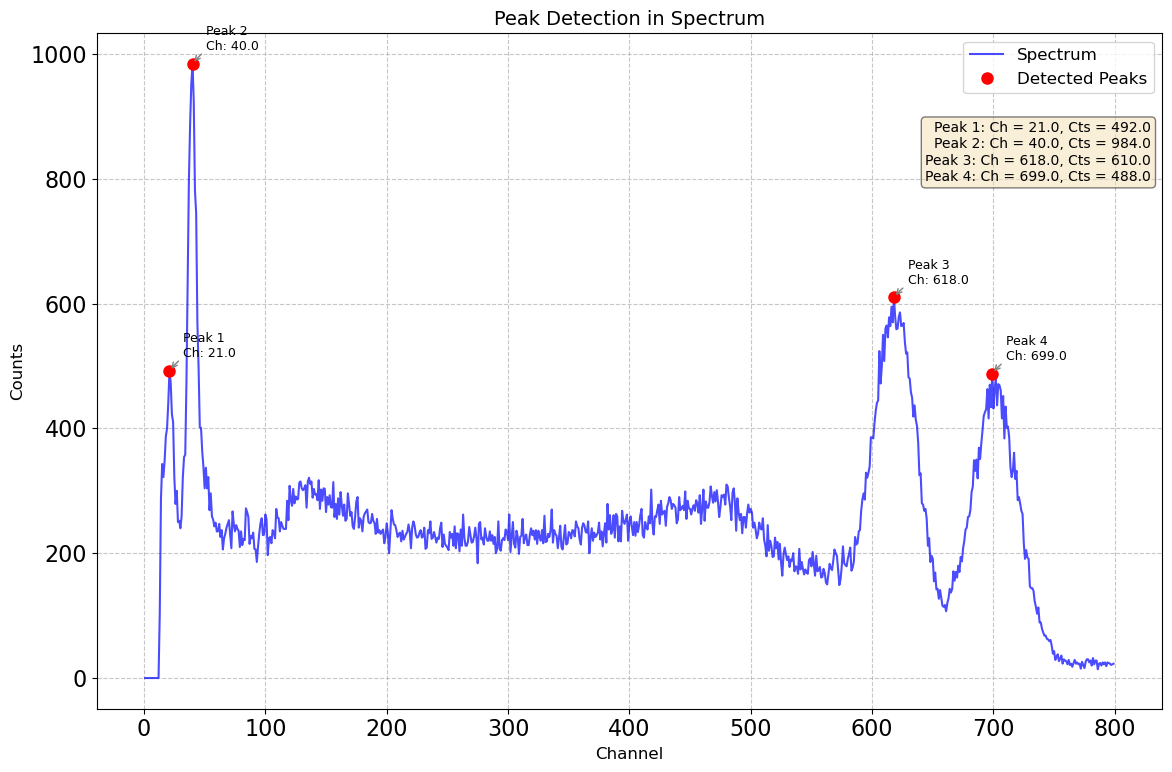

Detected Peaks:
   Peak_Number  Channel  Counts       FWHM  Prominence
0            1     21.0   492.0   7.038462       252.0
1            2     40.0   984.0   9.818757       970.0
2            3    618.0   610.0  39.045705       461.0
3            4    699.0   488.0  37.751284       381.0


In [10]:
# Peak locations
peak_df =  detect_peaks(data, max_channel=800, min_height=300, min_distance=4, min_prominence=200, min_width=4, plot=True)
peakLoc= peak_df['Channel']

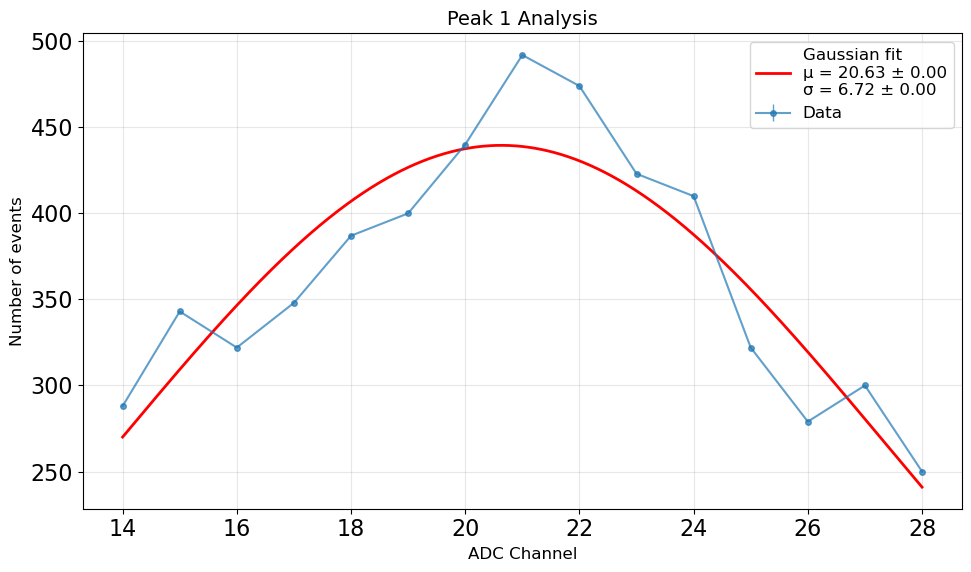


--- Results for Peak 1 Analysis ---
mean: 20.632466094230942
mean_er: 0.0003372520389985491
sigma: 6.719258156761638
sigma_er: 0.0005841689300766558
amplitude: 439.513446794241
amplitude_er: 0.01848641911864534
energy: unknown
fit_type: gaussian


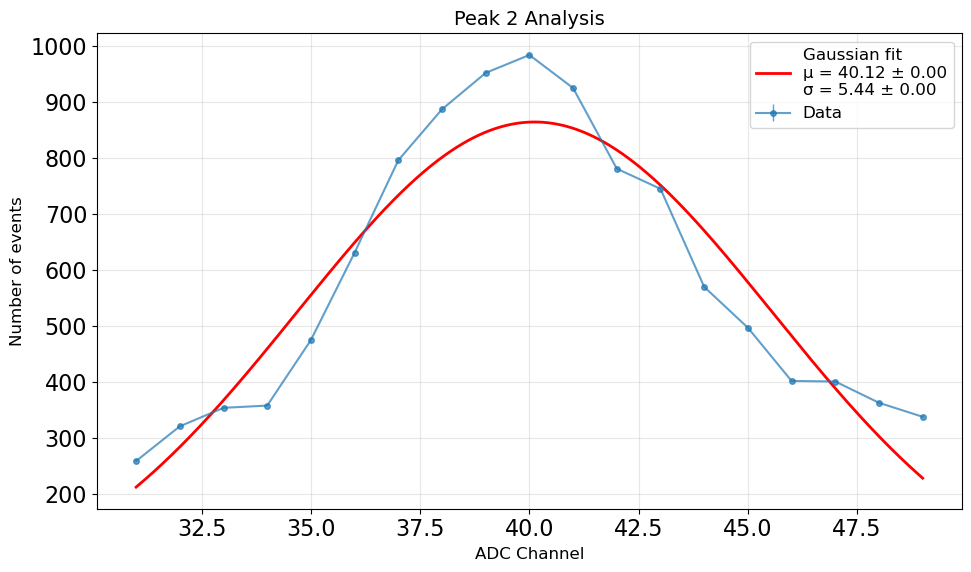


--- Results for Peak 2 Analysis ---
mean: 40.119702067630556
mean_er: 0.00013806073467771416
sigma: 5.443515590393739
sigma_er: 0.00016165008079033243
amplitude: 864.3682242431154
amplitude_er: 0.02480592496744859
energy: unknown
fit_type: gaussian


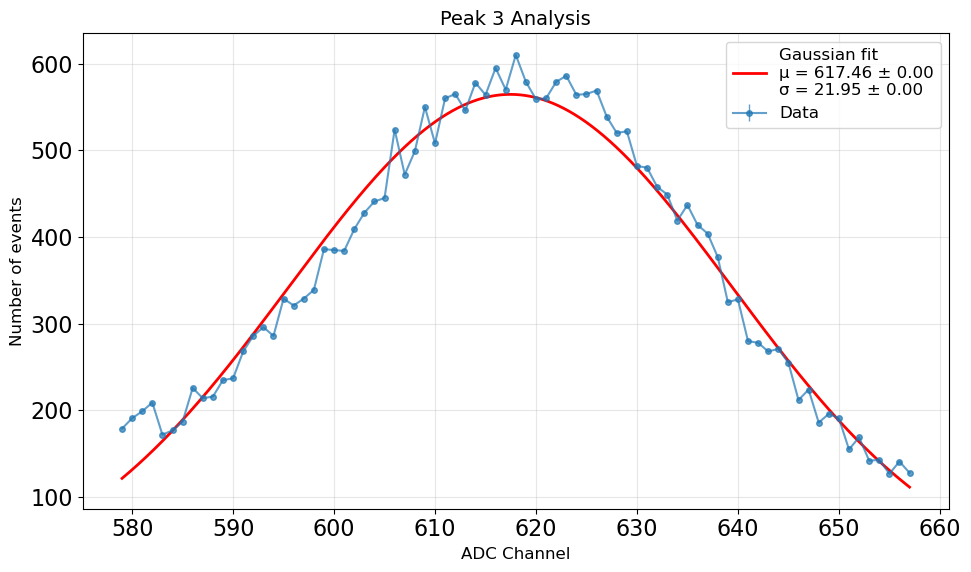


--- Results for Peak 3 Analysis ---
mean: 617.4647593074206
mean_er: 0.0003355328893321271
sigma: 21.953002570871774
sigma_er: 0.00036722016504766425
amplitude: 564.5618528884994
amplitude_er: 0.009705945408811254
energy: 1173.2
fit_type: gaussian


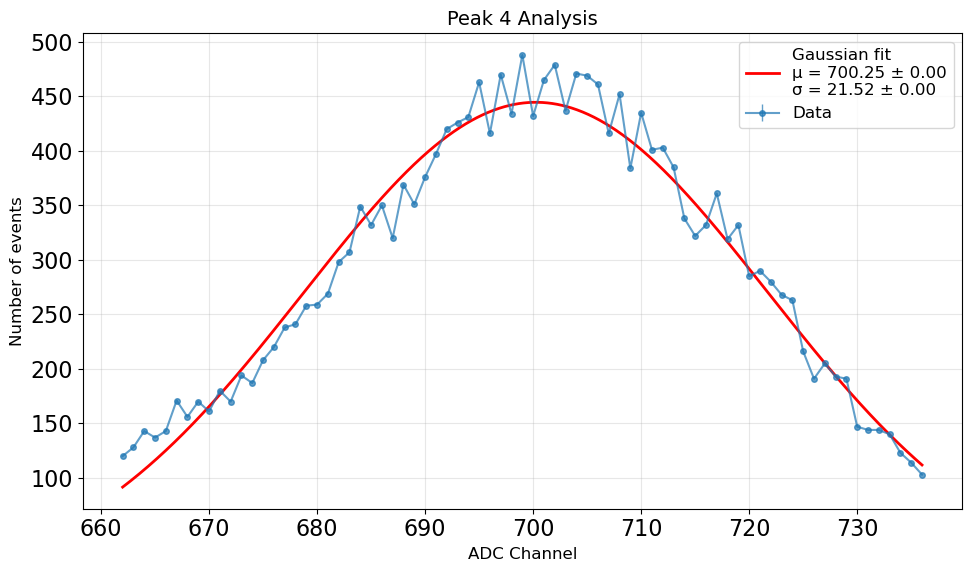


--- Results for Peak 4 Analysis ---
mean: 700.253331541549
mean_er: 0.00038266179781835155
sigma: 21.51720786434803
sigma_er: 0.0004284032982111109
amplitude: 444.60499574105876
amplitude_er: 0.008756980641487477
energy: 1332.5
fit_type: gaussian


In [11]:
#Peak analysis
peaks_energies_Co=[0,0,1173.2,1332.5]
# widths = [float(peak_df.FWHM.iloc[0])-2,float(peak_df.FWHM.iloc[1]),float(peak_df.FWHM.iloc[2])]
meansCo, mean_errsCo, sigmasCo, sigma_errsCo = analyze_spectrum_peaks(
    data=data,
    peakLoc=peakLoc,
    peak_df=peak_df,peaks_energies=peaks_energies_Co)


## Americium 241

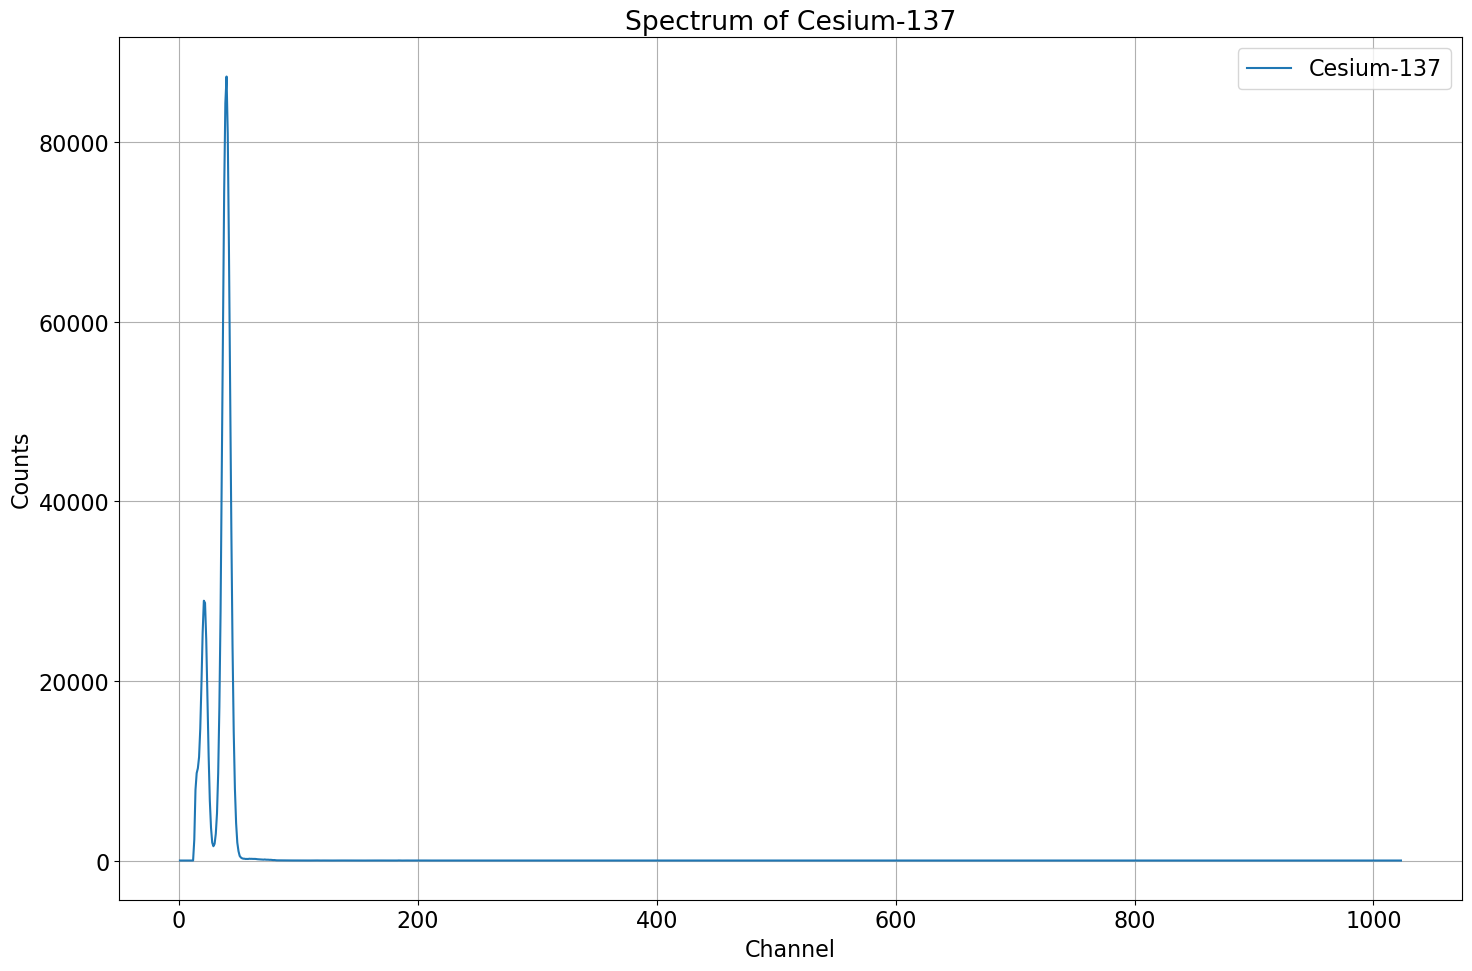

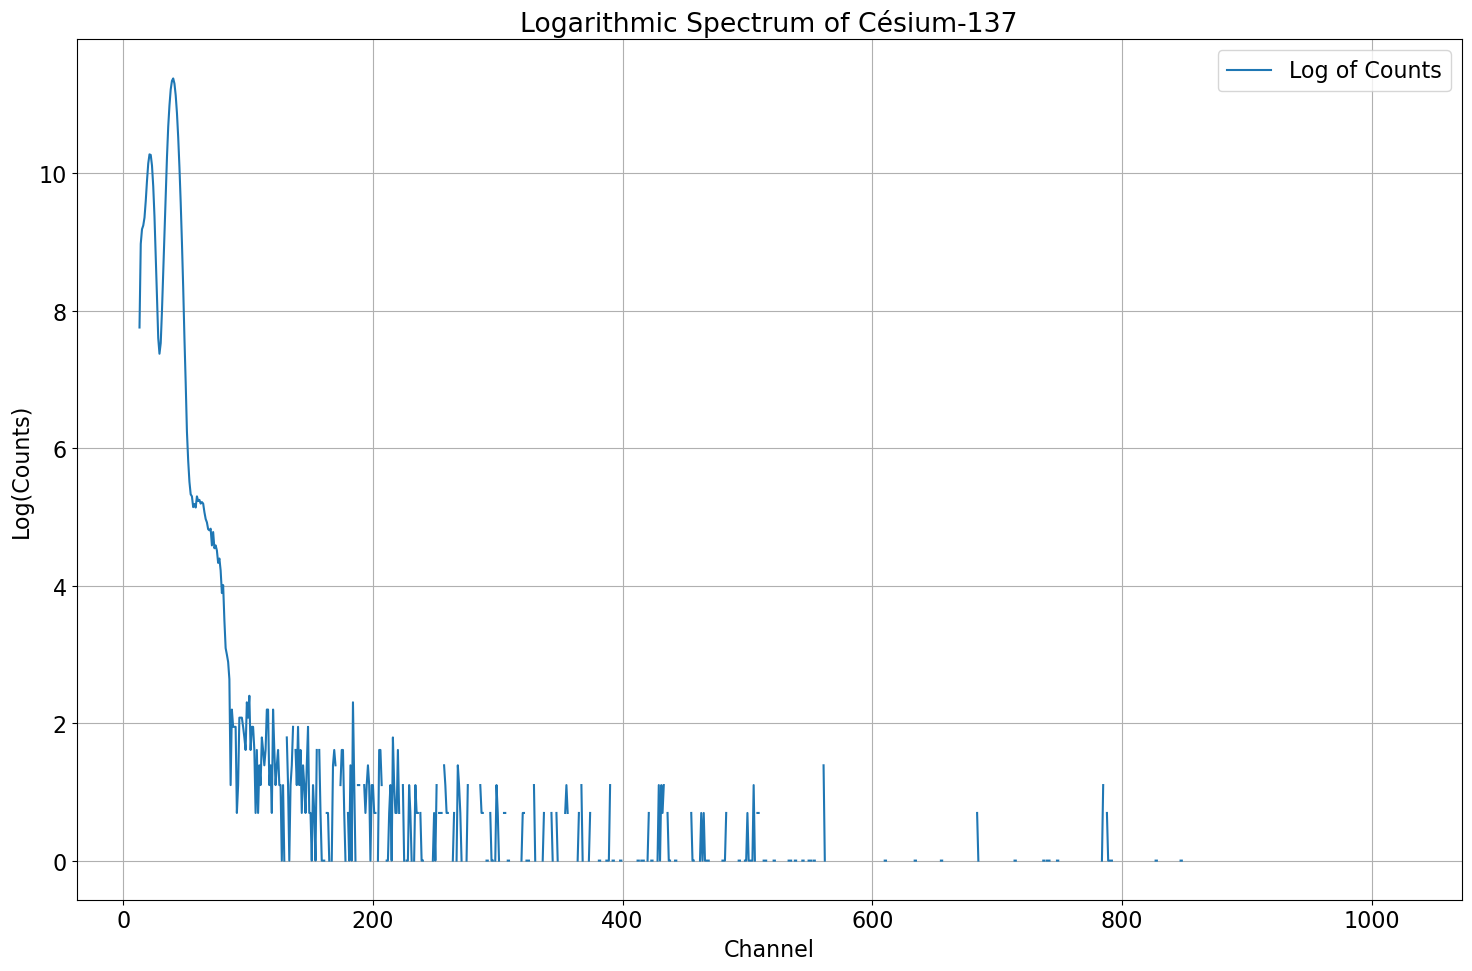

In [12]:
# File path
filename = '/home/dbaconsult/Downloads/PHYSF210/PTM/Detecteur1/Am241.txt'

# Read the file
fileAm = codecs.open(filename, encoding = "ISO-8859-1")
data = read_file(fileAm)

# Plot: raw data
plt.figure()
plt.plot(data['channel'], data['N'], label="Cesium-137")
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.title("Spectrum of Cesium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: log-transformed data
plt.figure()
plt.plot(data['channel'], np.log(data['N'].replace(0, np.nan)), label="Log of Counts")  # Avoid log(0)
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Log(Counts)")
plt.title("Logarithmic Spectrum of Césium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

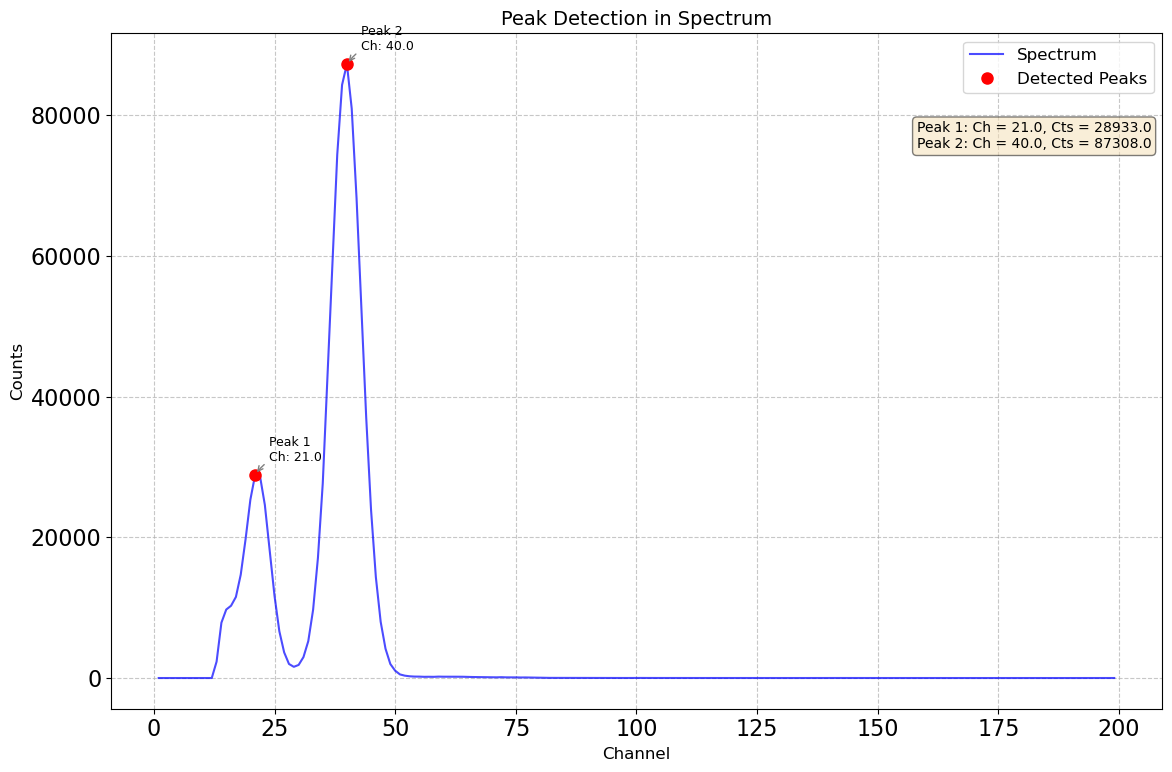

Detected Peaks:
   Peak_Number  Channel   Counts      FWHM  Prominence
0            1     21.0  28933.0  6.334919     27341.0
1            2     40.0  87308.0  7.556178     87308.0


In [13]:
# Peak locations
peak_df =  detect_peaks(data, max_channel=200, min_height=300, min_distance=4, min_prominence=200, min_width=4, plot=True)
peakLoc= peak_df['Channel']

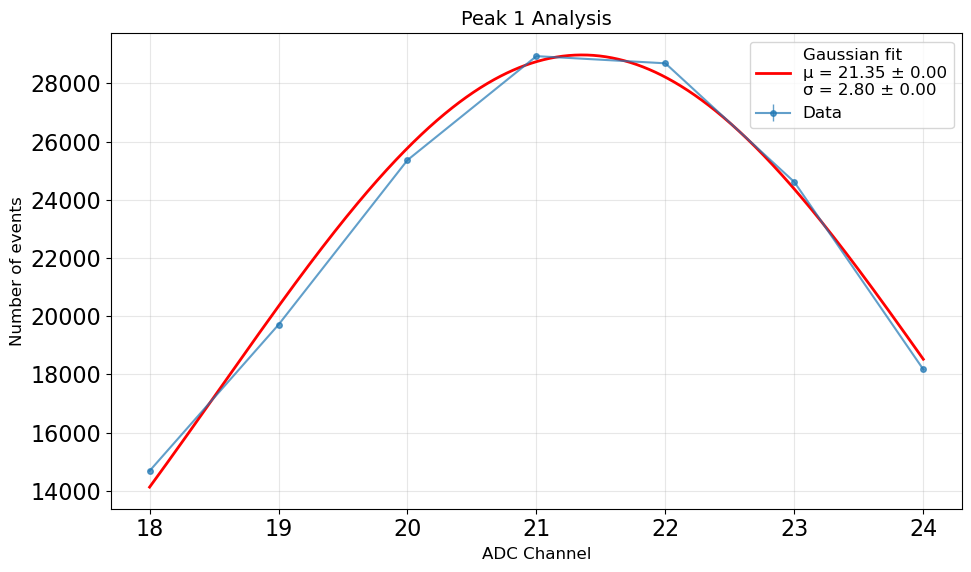


--- Results for Peak 1 Analysis ---
mean: 21.353176814901044
mean_er: 4.101329093033603e-05
sigma: 2.7978972208284296
sigma_er: 6.177444798077912e-05
amplitude: 28974.429826703272
amplitude_er: 0.37210599573878744
energy: 26.3
fit_type: gaussian


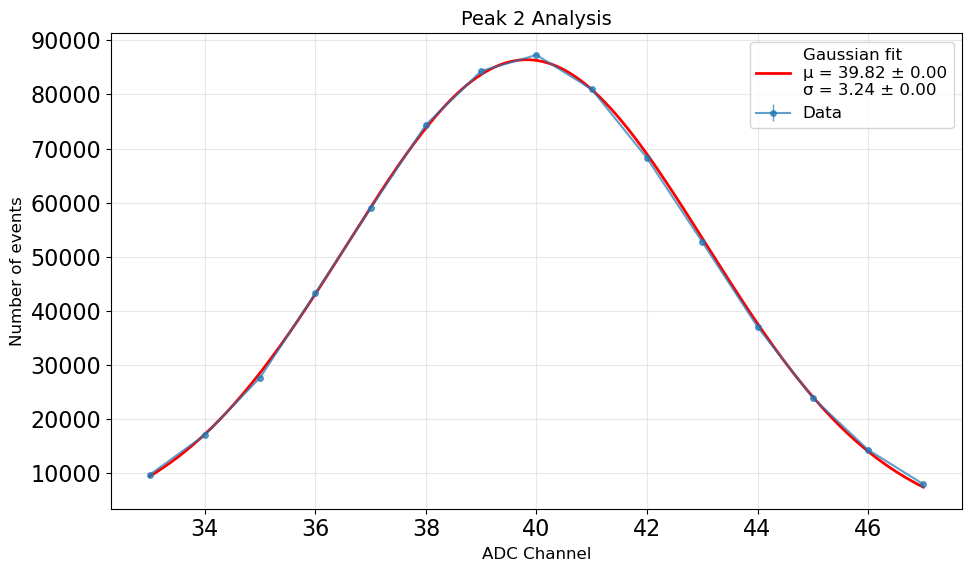


--- Results for Peak 2 Analysis ---
mean: 39.82234595927123
mean_er: 1.5210440257721574e-05
sigma: 3.24184278954959
sigma_er: 1.3281737715915284e-05
amplitude: 86428.68488502021
amplitude_er: 0.4881105696480322
energy: 59.6
fit_type: gaussian


In [14]:
#Peak analysis
peaks_energies_Am=[26.3,59.6]
widths = [float(peak_df.FWHM.iloc[0])-3,float(peak_df.FWHM.iloc[1])]
meansAm, mean_errsAm, sigmasAm, sigma_errsAm = analyze_spectrum_peaks(
    data=data,
    peakLoc=peakLoc,
    peak_df=peak_df,peaks_energies=peaks_energies_Am,widths=widths)

## Sodium 22

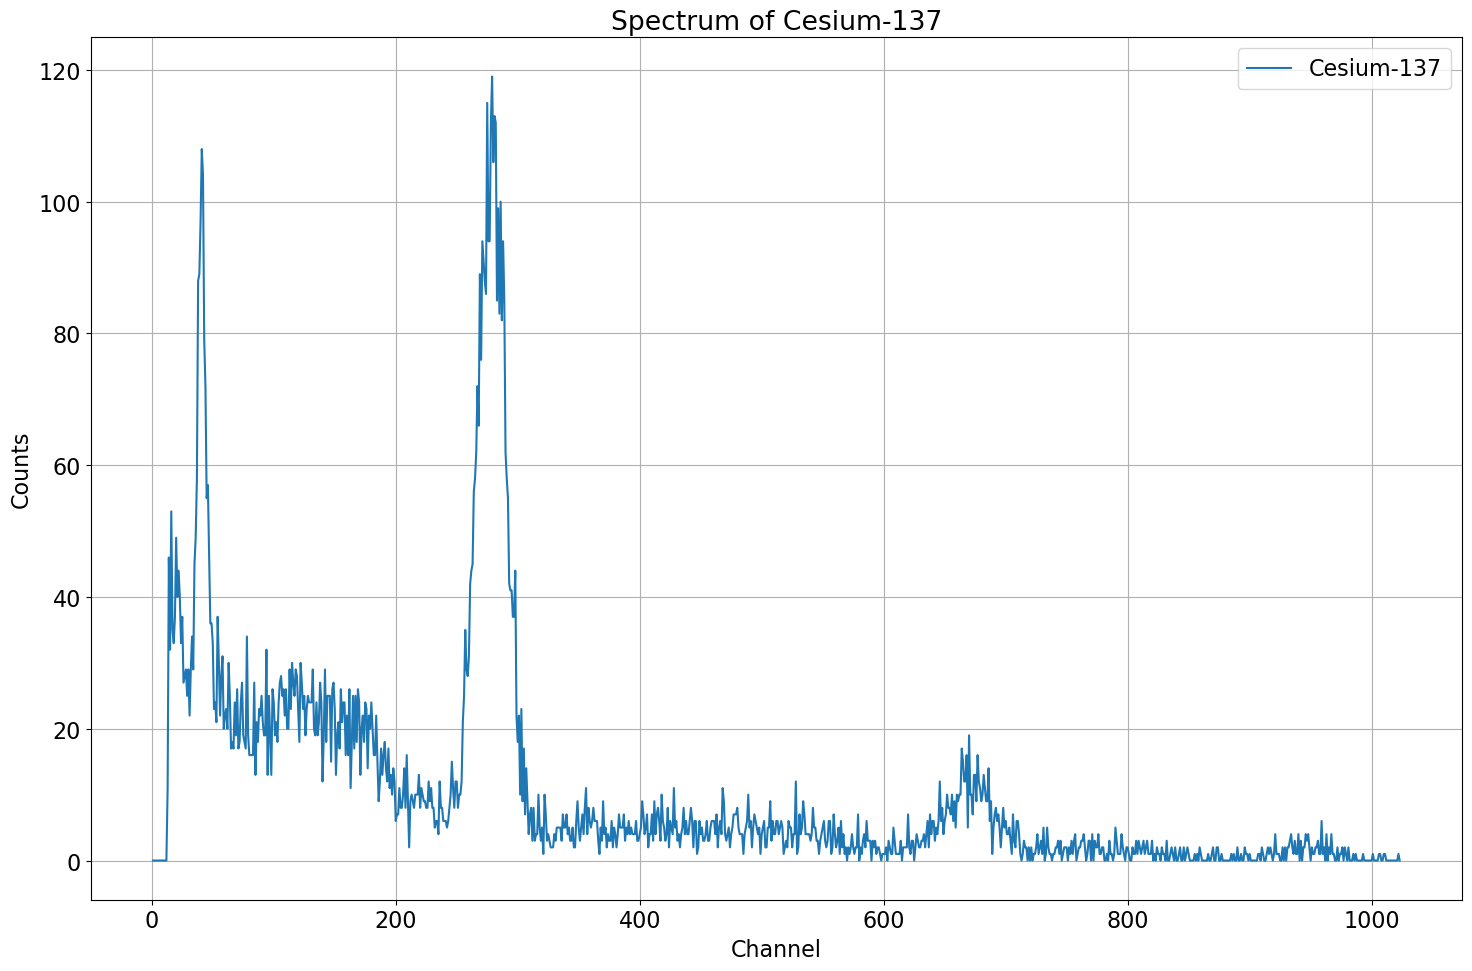

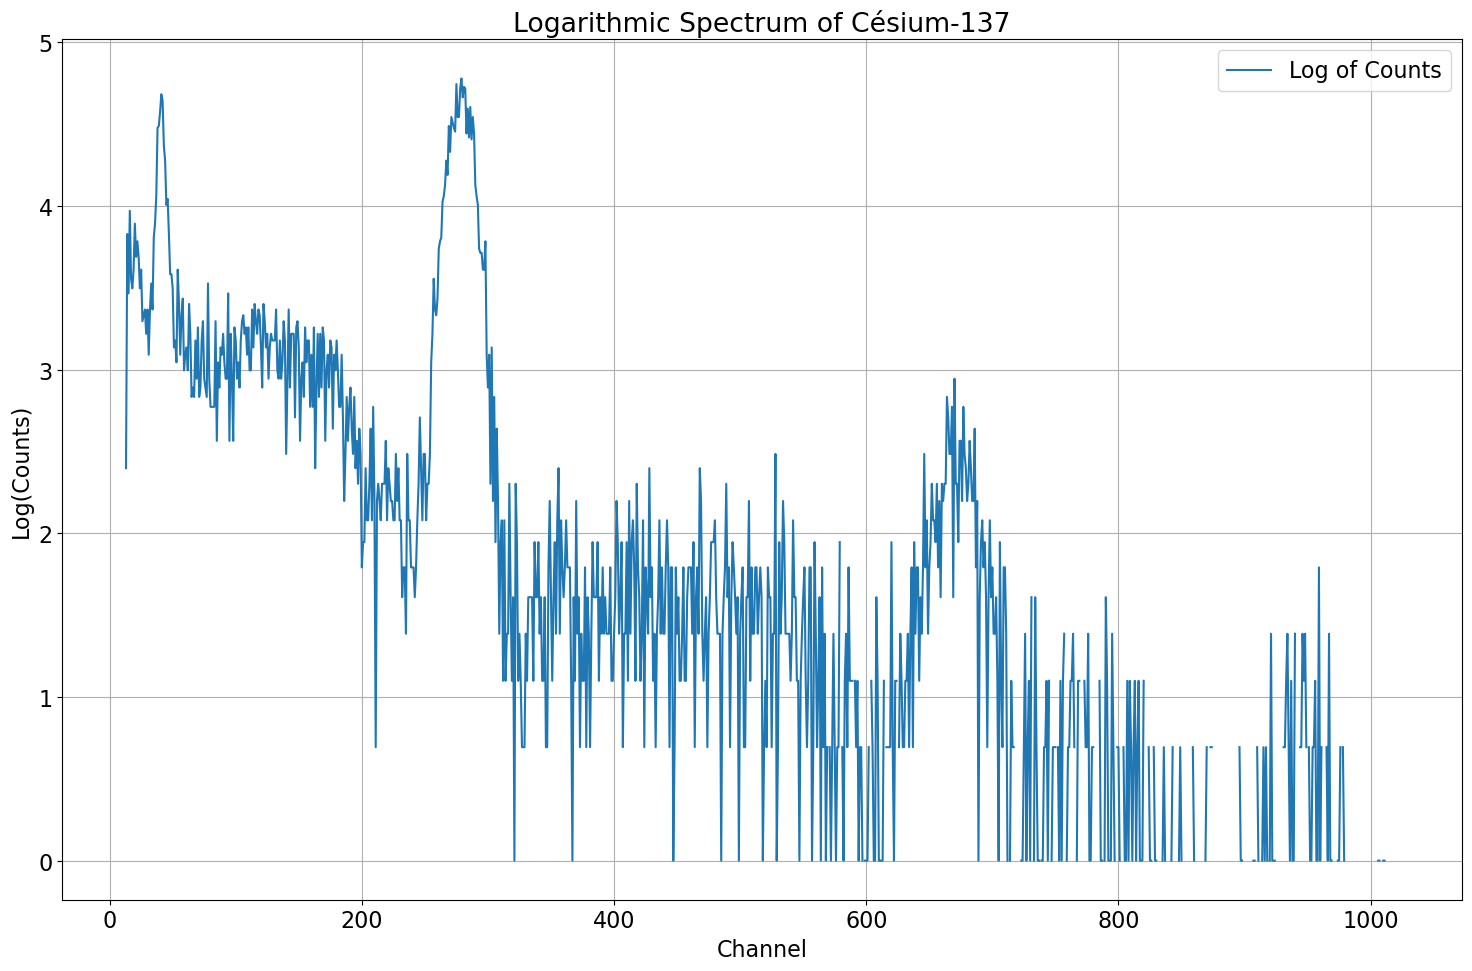

In [15]:
# File path
filename = '/home/dbaconsult/Downloads/PHYSF210/PTM/Detecteur1/Na22.txt'

# Read the file
fileNa = codecs.open(filename, encoding = "ISO-8859-1")
data = read_file(fileNa)

# Plot: raw data
plt.figure()
plt.plot(data['channel'], data['N'], label="Cesium-137")
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.title("Spectrum of Cesium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: log-transformed data
plt.figure()
plt.plot(data['channel'], np.log(data['N'].replace(0, np.nan)), label="Log of Counts")  # Avoid log(0)
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Log(Counts)")
plt.title("Logarithmic Spectrum of Césium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

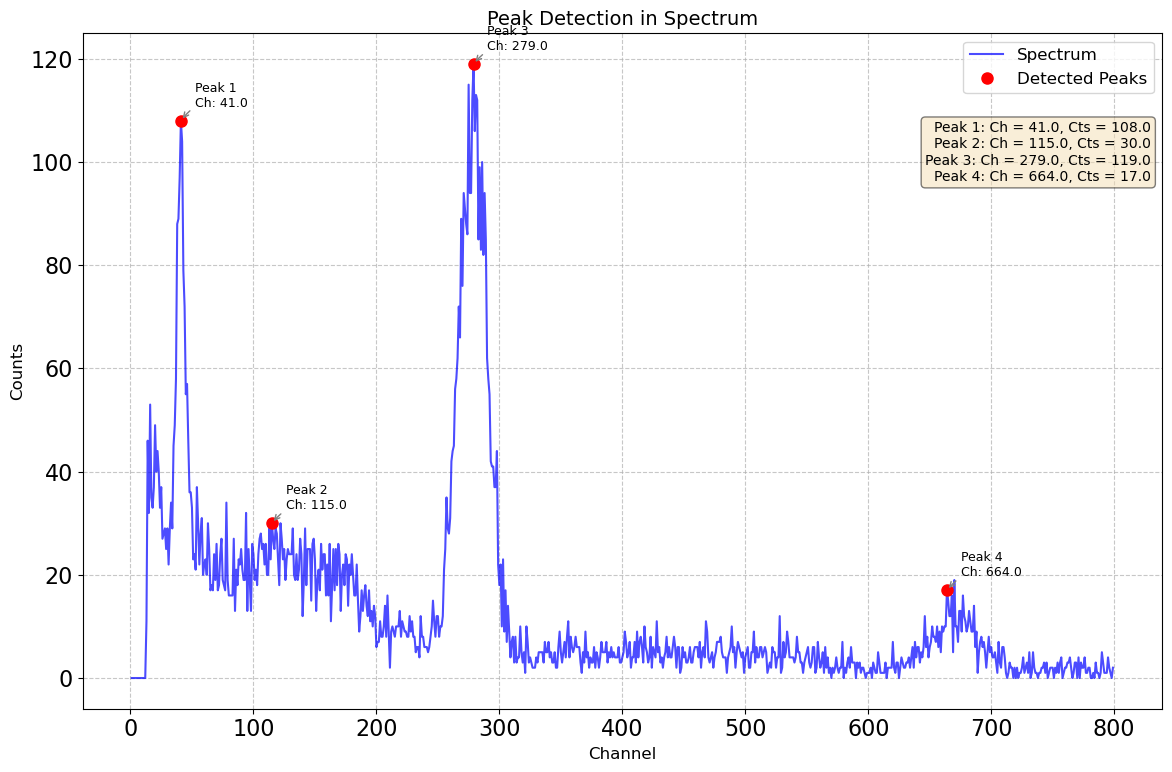

Detected Peaks:
   Peak_Number  Channel  Counts       FWHM  Prominence
0            1     41.0   108.0   8.333333       106.0
1            2    115.0    30.0   8.133333        17.0
2            3    279.0   119.0  25.250000       119.0
3            4    664.0    17.0   5.311688        12.0


In [16]:
# Peak locations
peak_df =  detect_peaks(data, max_channel=800, min_height=10, min_distance=6, min_prominence=10, min_width=5, plot=True)
peakLoc= peak_df['Channel']

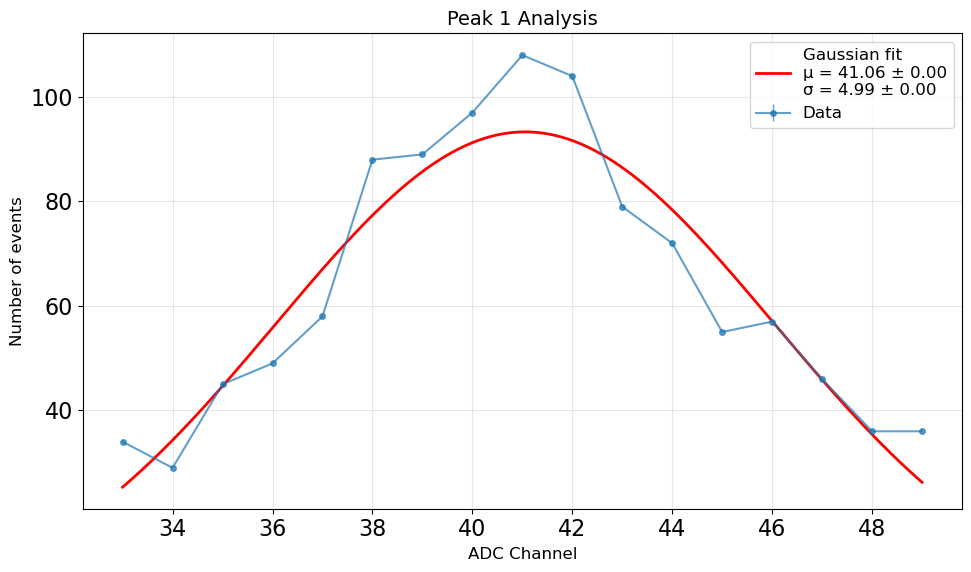


--- Results for Peak 1 Analysis ---
mean: 41.05596369268769
mean_er: 0.0007843344554500107
sigma: 4.98709119654087
sigma_er: 0.0009265368667418518
amplitude: 93.31572141916456
amplitude_er: 0.01634662335143186
energy: unknown
fit_type: gaussian


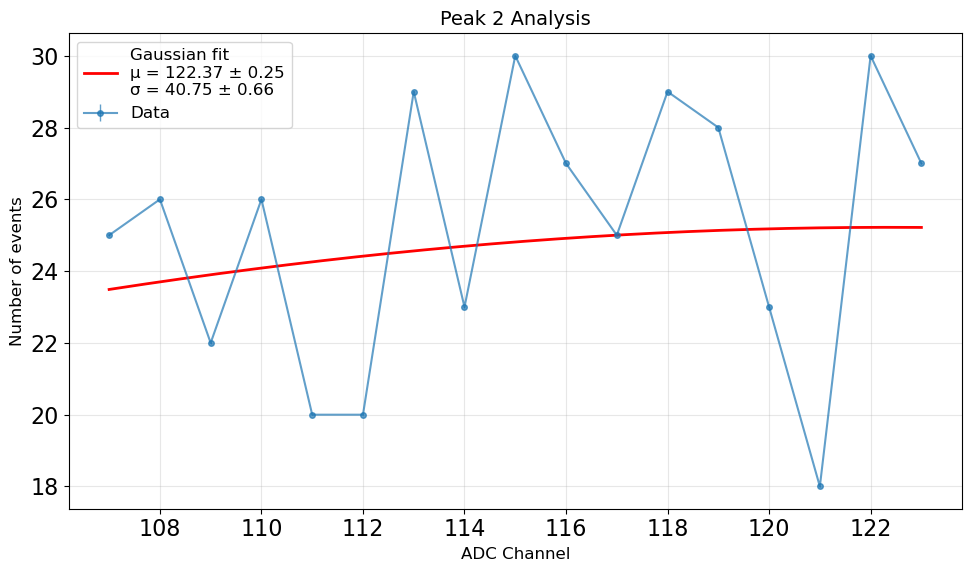


--- Results for Peak 2 Analysis ---
mean: 122.36517610789737
mean_er: 0.24568092737545863
sigma: 40.74639165827181
sigma_er: 0.6597617772945286
amplitude: 25.219938110740944
amplitude_er: 0.011612556558960426
energy: unknown
fit_type: gaussian


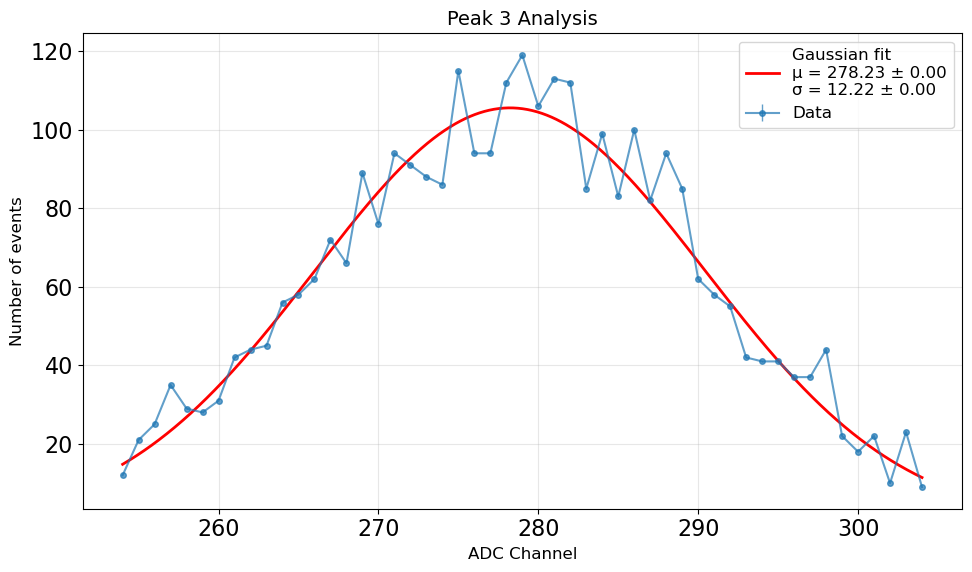


--- Results for Peak 3 Analysis ---
mean: 278.22849926599235
mean_er: 0.0010136747720397889
sigma: 12.222119883290182
sigma_er: 0.0009504260516491945
amplitude: 105.56511717929023
amplitude_er: 0.01022532387681452
energy: 510
fit_type: gaussian


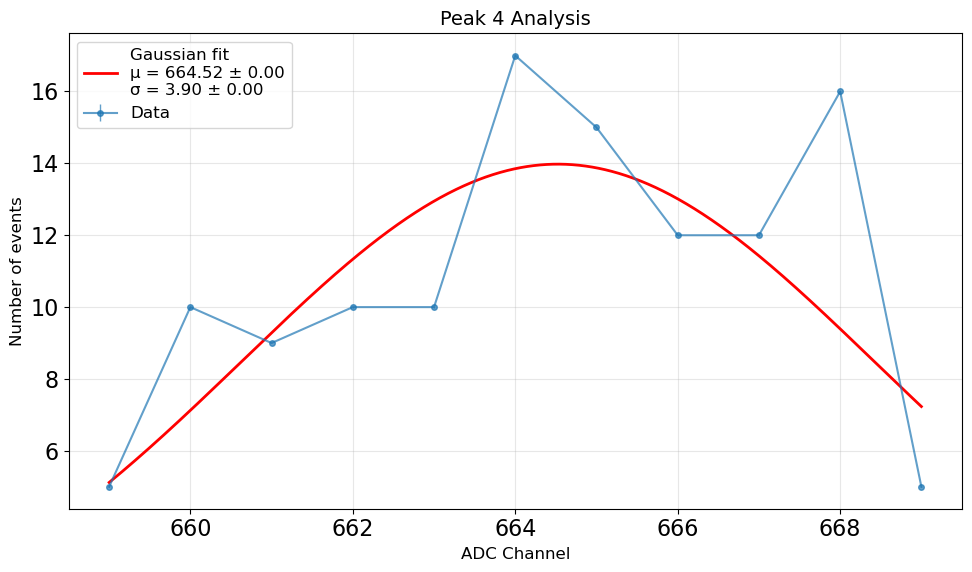


--- Results for Peak 4 Analysis ---
mean: 664.524984916218
mean_er: 0.002152758522961966
sigma: 3.89843312565697
sigma_er: 0.0028169652084941267
amplitude: 13.978166110128104
amplitude_er: 0.00740078666644632
energy: 1274.53
fit_type: gaussian


In [17]:
#Peak analysis
peaks_energies_Na=[0,0,510,1274.53]
#widths = [float(peak_df.FWHM.iloc[0])-3,float(peak_df.FWHM.iloc[1])]
meansNa, mean_errsNa, sigmasNa, sigma_errsNa = analyze_spectrum_peaks(
    data=data,
    peakLoc=peakLoc,
    peak_df=peak_df,peaks_energies=peaks_energies_Na)

## Calibration of the detector

In [18]:
print(peaks_energies_Cs)
print(peaks_energies_Co)
print(peaks_energies_Na)
print(peaks_energies_Am)
print(peaks_energies_Ba)

[0, 0, 661.657]
[0, 0, 1173.2, 1332.5]
[0, 0, 510, 1274.53]
[26.3, 59.6]
[0, 81.0, 0, 0, 356.02]


In [19]:
 meansCo[2]

617.4647593074206

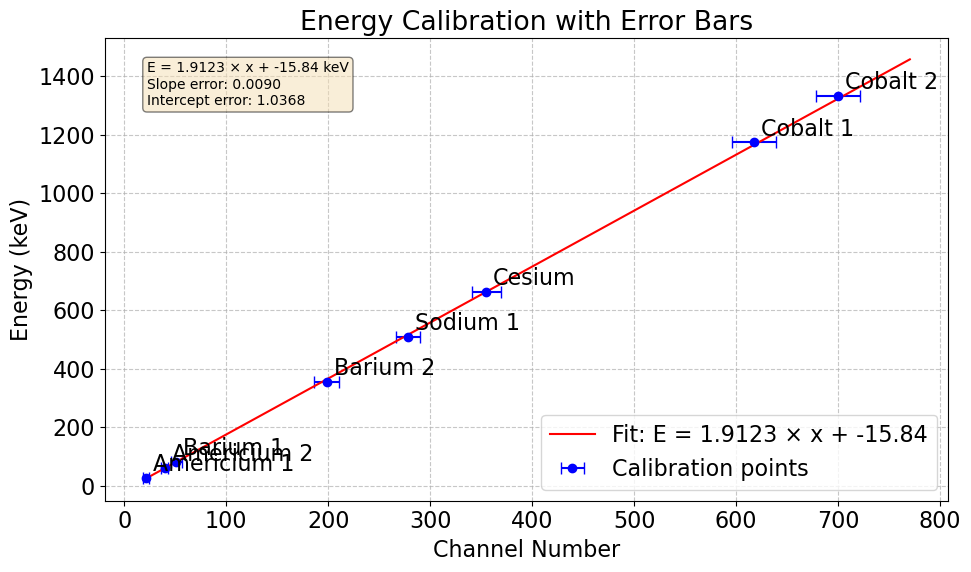

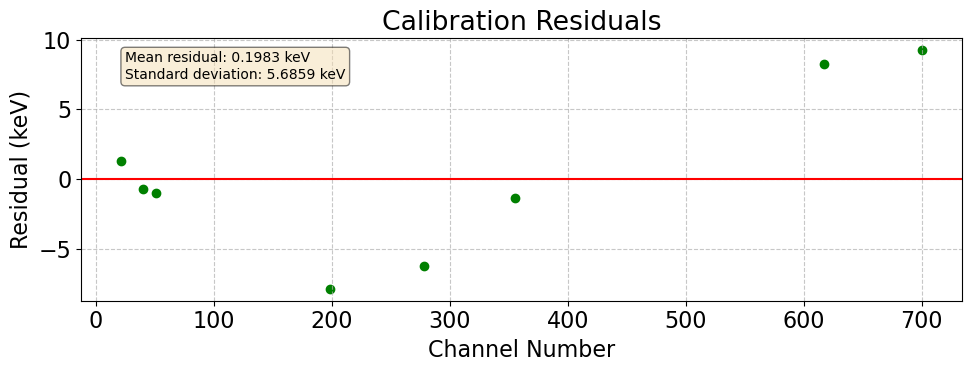

Calibration function: E(channel) = 1.9123 × channel + -15.84 keV


In [20]:
from scipy.odr import ODR, Model, RealData

# Data
x = np.array([meansCs[2], meansCo[2], meansCo[3], meansNa[2],
              meansAm[0], meansAm[1], meansBa[1], meansBa[4]])
y = np.array([peaks_energies_Cs[2], peaks_energies_Co[2], peaks_energies_Co[3],
              peaks_energies_Na[2], peaks_energies_Am[0],
              peaks_energies_Am[1], peaks_energies_Ba[1], peaks_energies_Ba[4]])
x_errors = np.array([
    sigmasCs[2], sigmasCo[2], sigmasCo[3],
    sigmasNa[2], sigmasAm[0],
    sigmasAm[1], sigmasBa[1], sigmasBa[4]
])

# Plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, xerr=x_errors, fmt='o', color='blue', label='Calibration points', capsize=4)

# Annotate points
sources = ['Cesium', 'Cobalt 1', 'Cobalt 2', 'Sodium 1',
           'Americium 1', 'Americium 2', 'Barium 1', 'Barium 2']
for i, source in enumerate(sources):
    plt.annotate(source, (x[i], y[i]), xytext=(5, 5), textcoords='offset points')

# Define linear model for ODR
def linear_model(B, x):
    return B[0] * x + B[1]

# Perform ODR (Orthogonal Distance Regression)
linear = Model(linear_model)
data = RealData(x, y, sx=x_errors)
odr = ODR(data, linear, beta0=[1., 0.])
output = odr.run()

slope, intercept = output.beta
slope_err, intercept_err = output.sd_beta

# Fitted line
x_fit = np.linspace(min(x)*0.9, max(x)*1.1, 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linestyle='-', label=f'Fit: E = {slope:.4f} × x + {intercept:.2f}')

# Plot customization
plt.title('Energy Calibration with Error Bars')
plt.xlabel('Channel Number')
plt.ylabel('Energy (keV)')
plt.grid(True, linestyle='--', alpha=0.7)

# Show regression stats
textstr = '\n'.join((
    f'E = {slope:.4f} × x + {intercept:.2f} keV',
    f'Slope error: {slope_err:.4f}',
    f'Intercept error: {intercept_err:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.legend()
plt.tight_layout()
plt.show()

# Residuals
y_pred = slope * x + intercept
residuals = y - y_pred

plt.figure(figsize=(10, 4))
plt.scatter(x, residuals, color='green', marker='o')
plt.axhline(y=0, color='red', linestyle='-')
plt.title('Calibration Residuals')
plt.xlabel('Channel Number')
plt.ylabel('Residual (keV)')
plt.grid(True, linestyle='--', alpha=0.7)

# Residual statistics
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
textstr = '\n'.join((
    f'Mean residual: {mean_residual:.4f} keV',
    f'Standard deviation: {std_residual:.4f} keV'
))
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Calibration function with errors

def energy_error(channel,sigmaz):
    return np.sqrt((slope * sigmaz)**2 + (slope_err*channel)**2+intercept_err**2) 
def channel_to_energy(channel,sigmaz=None):
    if sigmaz==None:
        return print(f"{slope * channel + intercept:.2f}keV")
    else:
        return print(f"{slope * channel + intercept:.2f} ± {energy_error(channel,sigmaz):.2f} keV")
print("Calibration function: E(channel) = {:.4f} × channel + {:.2f} keV".format(slope, intercept))


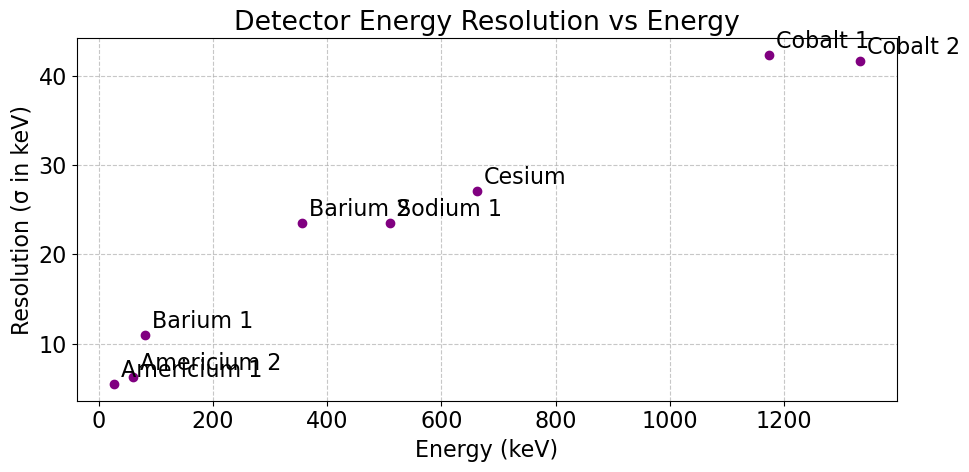

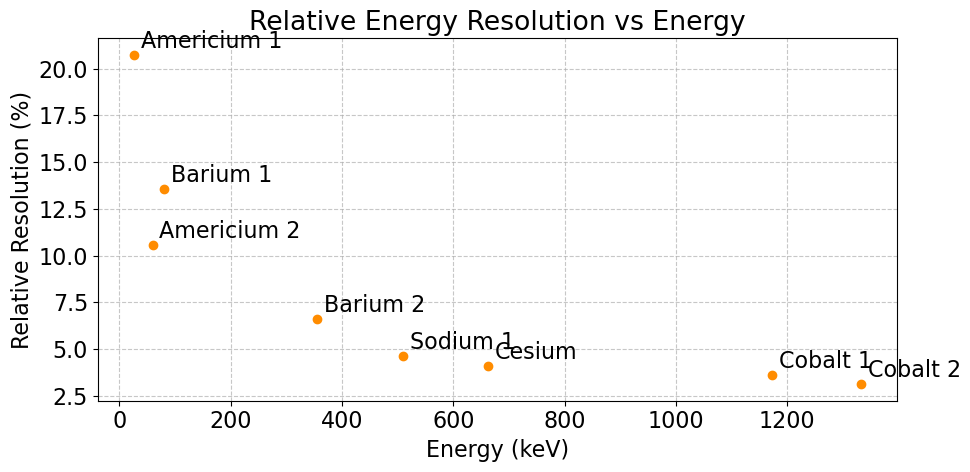

In [21]:
# Compute energy resolution: convert x_errors (in channels) to keV
energy_errors = np.sqrt((slope * x_errors)**2 + (slope_err*x)**2+intercept_err**2) 

# Absolute resolution plot
plt.figure(figsize=(10, 5))
plt.scatter(y, energy_errors, color='purple', marker='o')
plt.title('Detector Energy Resolution vs Energy')
plt.xlabel('Energy (keV)')
plt.ylabel('Resolution (σ in keV)')
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate source names
for i, source in enumerate(sources):
    plt.annotate(source, (y[i], energy_errors[i]), xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Relative resolution plot (%)
relative_resolution = (energy_errors/ y) * 100  # in percent

plt.figure(figsize=(10, 5))
plt.scatter(y, relative_resolution, color='darkorange', marker='o')
plt.title('Relative Energy Resolution vs Energy')
plt.xlabel('Energy (keV)')
plt.ylabel('Relative Resolution (%)')
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate source names
for i, source in enumerate(sources):
    plt.annotate(source, (y[i], relative_resolution[i]), xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


In [22]:
channel_to_energy(meansCs[0],sigmasCs[0])

29.42 ± 6.65 keV


In [23]:
channel_to_energy(meansCs[2],sigmasCs[2])

663.04 ± 27.08 keV


In [24]:
channel_to_energy(500)

940.32keV


## Background

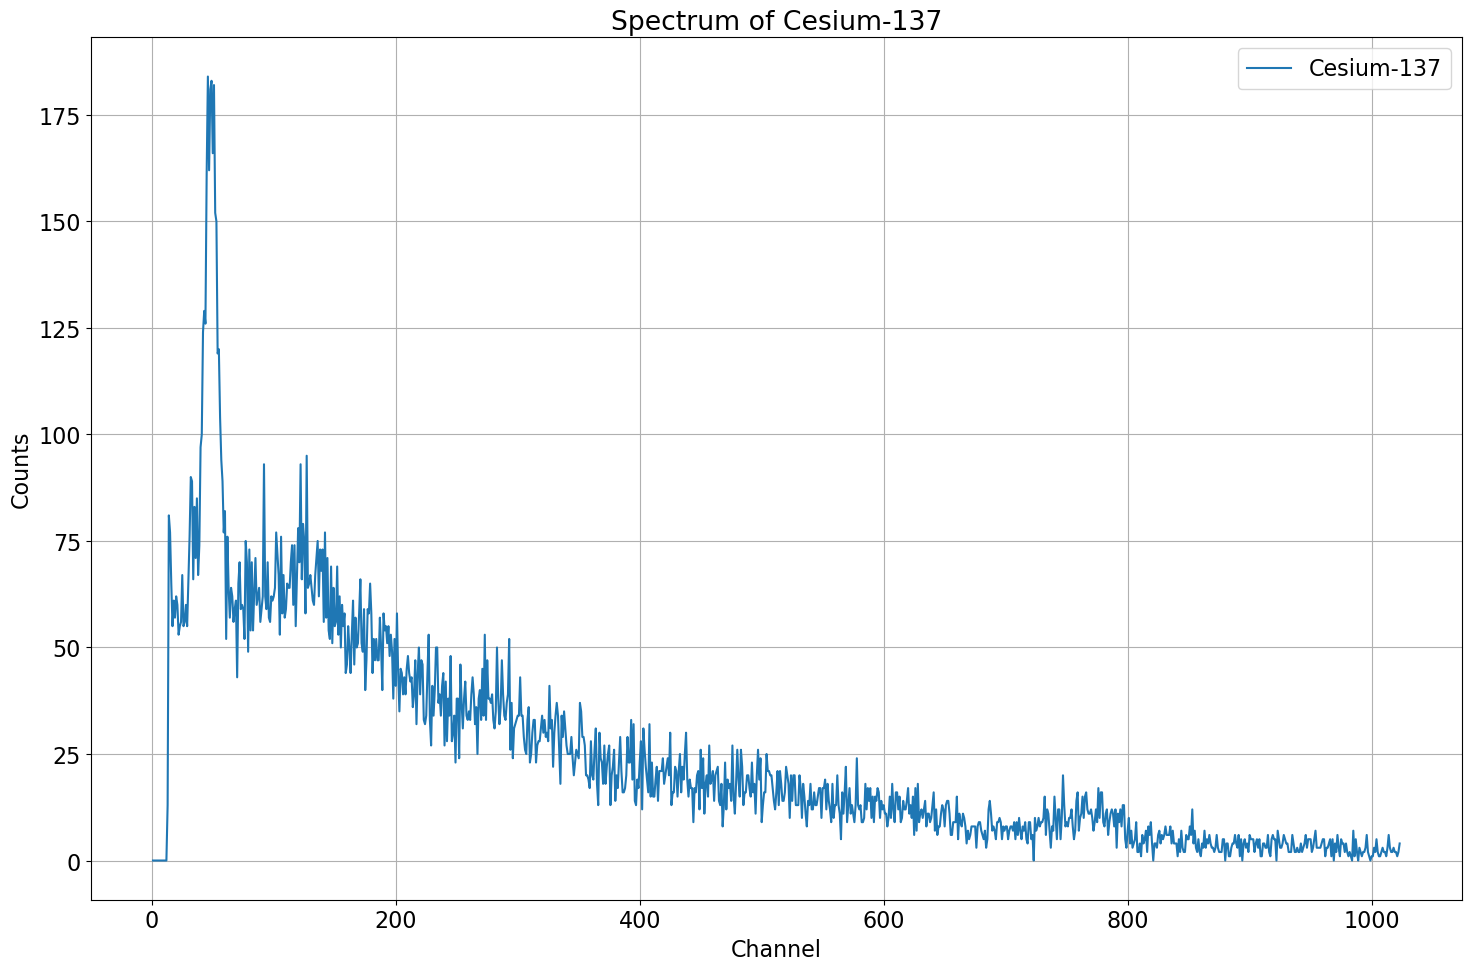

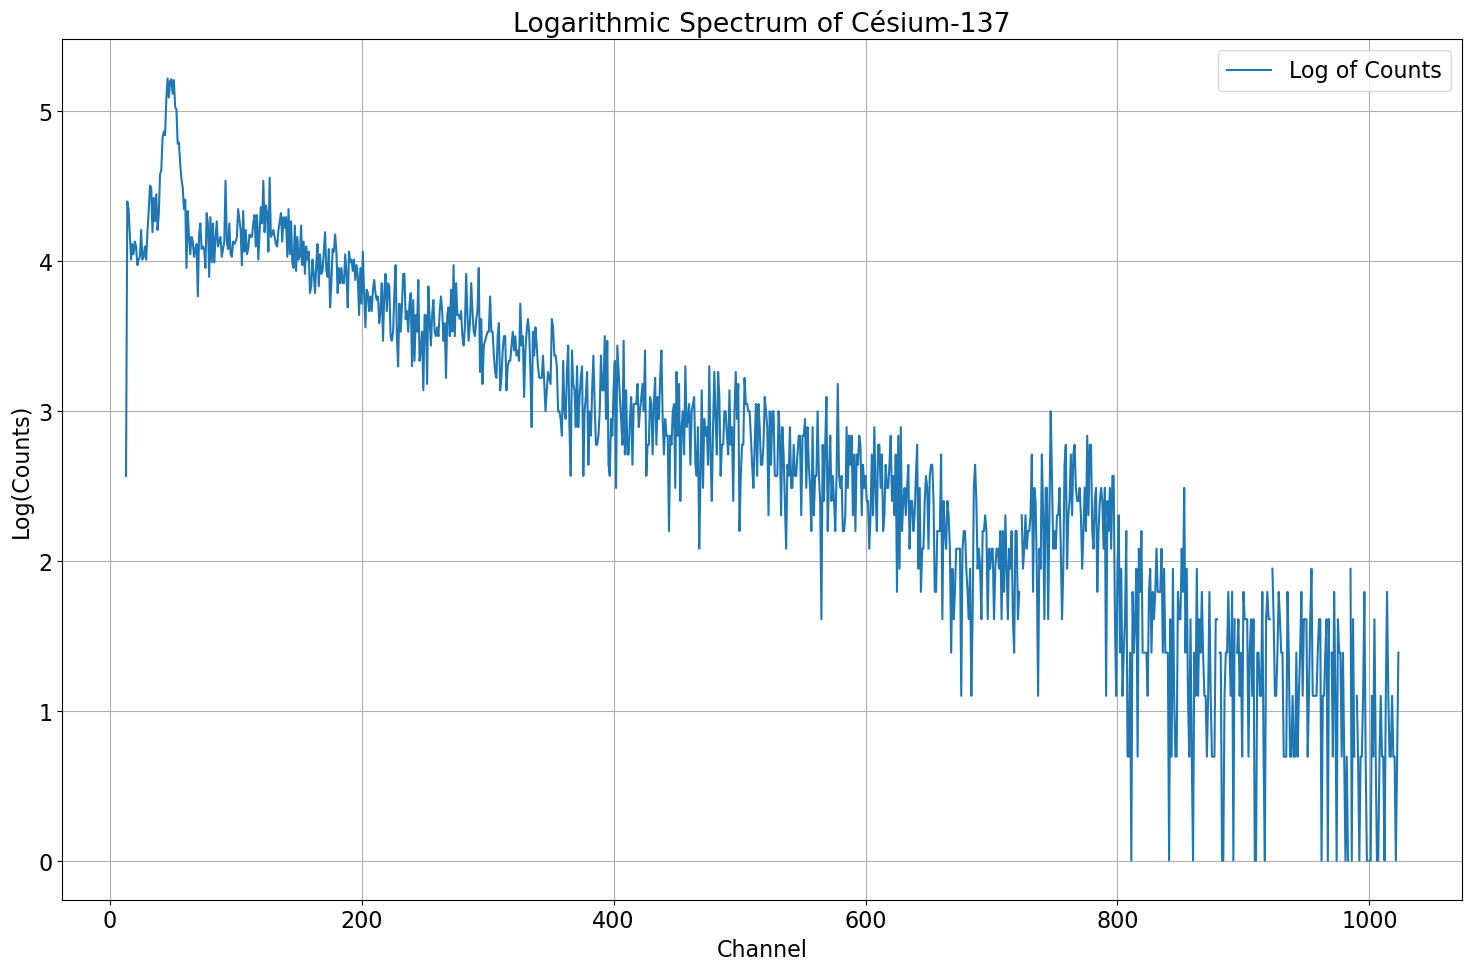

In [25]:
# File path
filename = '/home/dbaconsult/Downloads/PHYSF210/PTM/Detecteur1/BruitdeFond.txt'

# Read the file
fileBG = codecs.open(filename, encoding = "ISO-8859-1")
data = read_file(fileBG)

# Plot: raw data
plt.figure()
plt.plot(data['channel'], data['N'], label="Cesium-137")
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.title("Spectrum of Cesium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: log-transformed data
plt.figure()
plt.plot(data['channel'], np.log(data['N'].replace(0, np.nan)), label="Log of Counts")  # Avoid log(0)
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Log(Counts)")
plt.title("Logarithmic Spectrum of Césium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

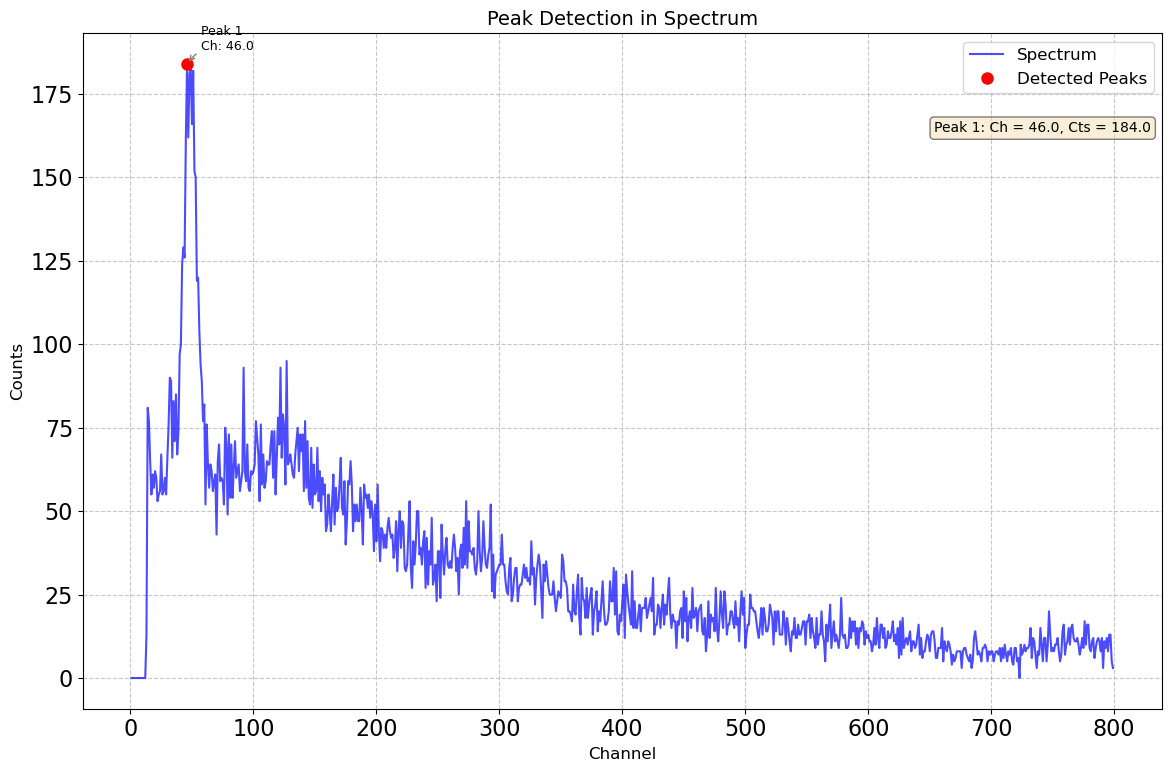

Detected Peaks:
   Peak_Number  Channel  Counts       FWHM  Prominence
0            1     46.0   184.0  17.617391       184.0


In [26]:
# Peak locations
peak_df =  detect_peaks(data, max_channel=800, min_height=100, min_distance=6, min_prominence=10, min_width=5, plot=True)
peakLoc= peak_df['Channel']

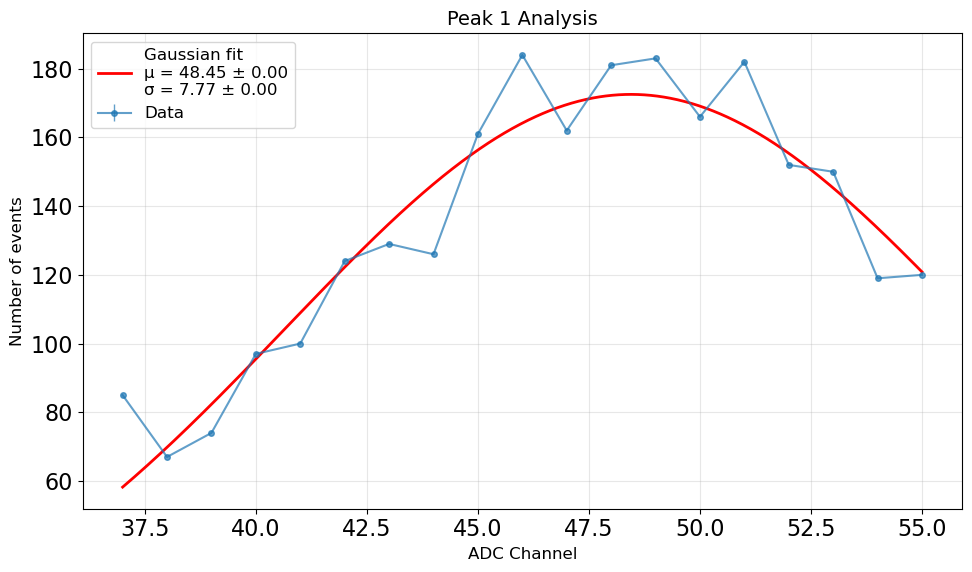


--- Results for Peak 1 Analysis ---
mean: 48.447217523235906
mean_er: 3.8898714989671275e-05
sigma: 7.766529476208324
sigma_er: 4.9528572057792945e-05
amplitude: 172.51926967105487
amplitude_er: 0.0005920705757170189
energy: unknown
fit_type: gaussian


In [27]:
#Peak analysis
peaks_energies_BG=[0]
widths = [float(peak_df.FWHM.iloc[0])-8]
meansBG, mean_errsBG, sigmasBG, sigma_errsBG = analyze_spectrum_peaks(
    data=data,
    peakLoc=peakLoc,
    peak_df=peak_df,peaks_energies=peaks_energies_BG,widths=widths )

In [28]:
channel_to_energy(meansBG[0],sigmasBG[0])

76.81 ± 14.89 keV


## Ouraline

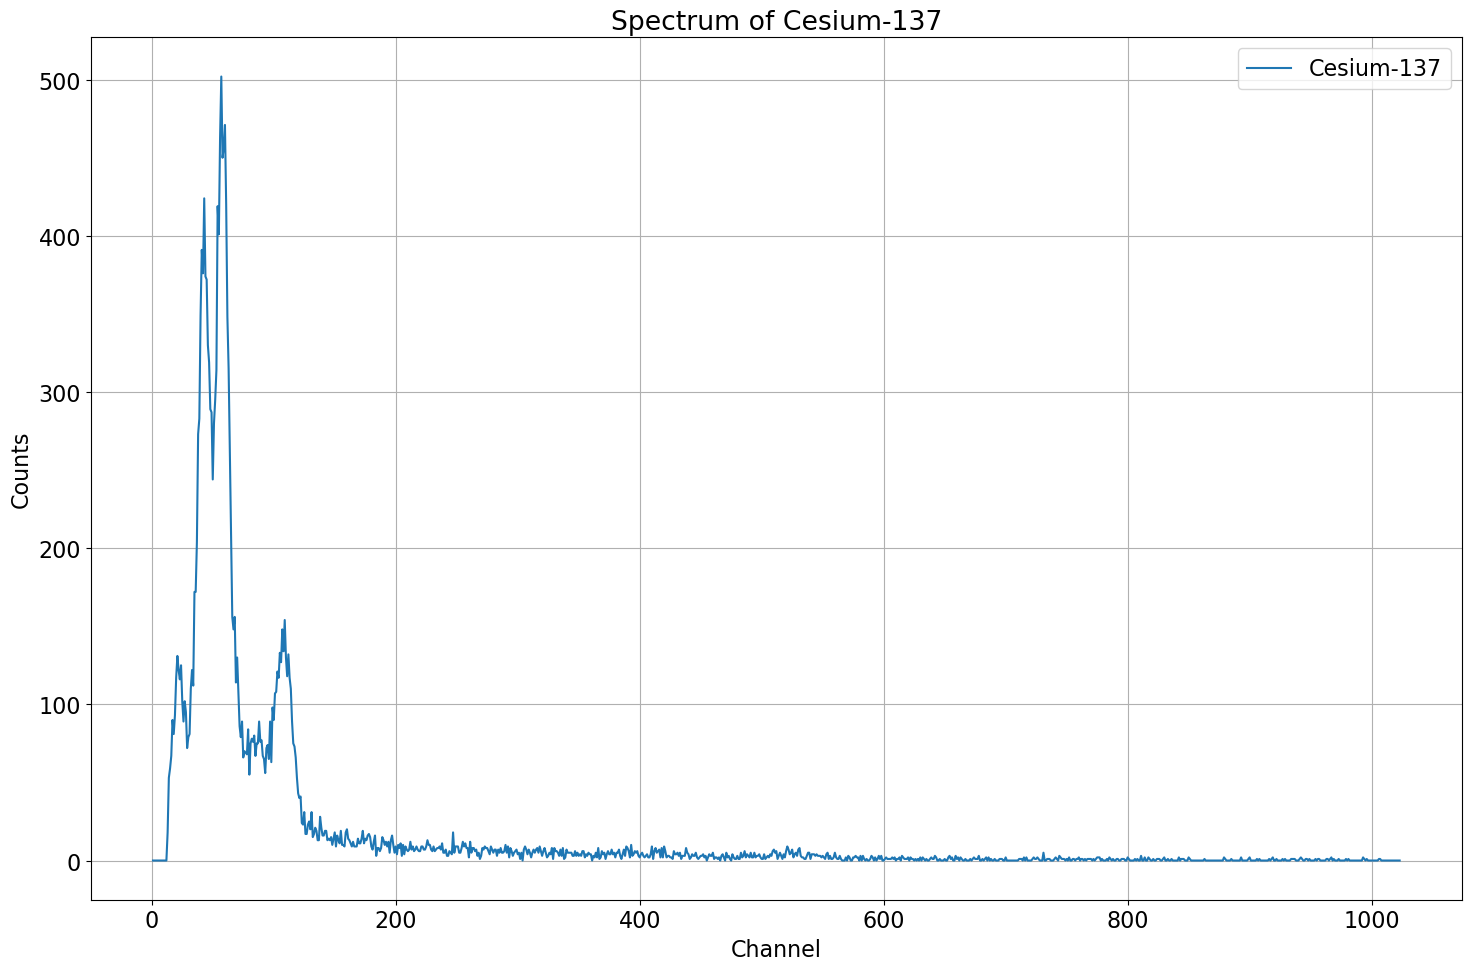

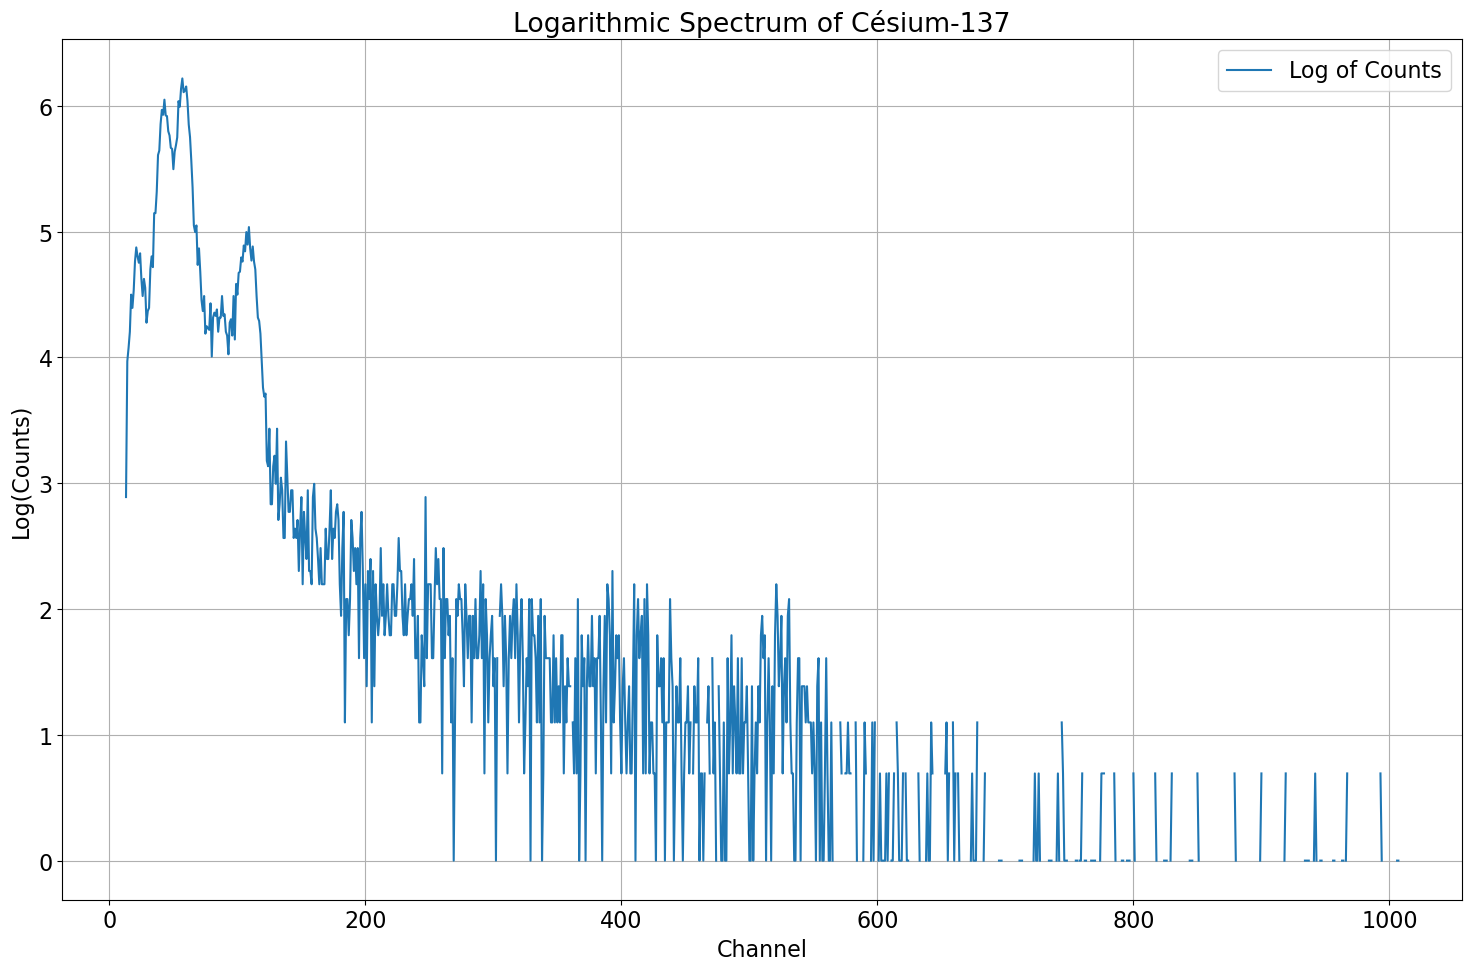

In [29]:
# File path
filename = '/home/dbaconsult/Downloads/PHYSF210/PTM/Detecteur1/Ouraline.txt'

# Read the file
fileOu = codecs.open(filename, encoding = "ISO-8859-1")
data = read_file(fileOu)

# Plot: raw data
plt.figure()
plt.plot(data['channel'], data['N'], label="Cesium-137")
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.title("Spectrum of Cesium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: log-transformed data
plt.figure()
plt.plot(data['channel'], np.log(data['N'].replace(0, np.nan)), label="Log of Counts")  # Avoid log(0)
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Log(Counts)")
plt.title("Logarithmic Spectrum of Césium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

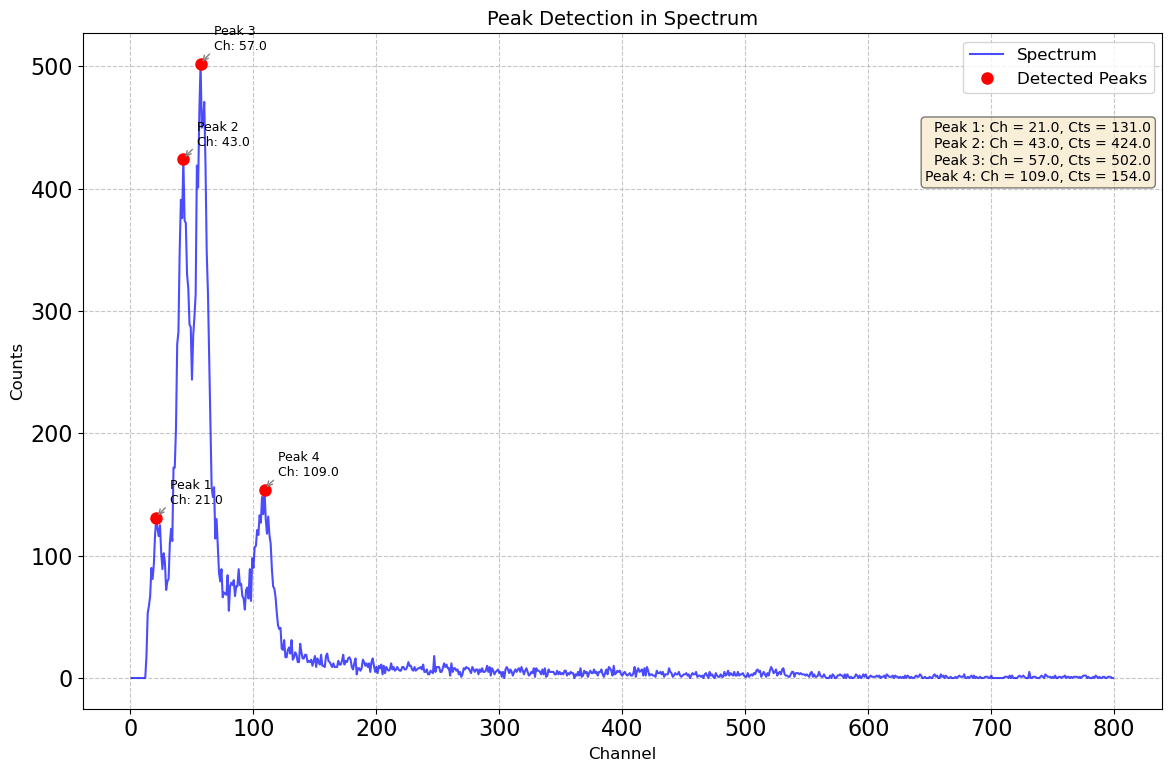

Detected Peaks:
   Peak_Number  Channel  Counts       FWHM  Prominence
0            1     21.0   131.0   5.684295        59.0
1            2     43.0   424.0   6.132035       180.0
2            3     57.0   502.0  14.005556       502.0
3            4    109.0   154.0  13.408964        99.0


In [30]:
# Peak locations
peak_df =  detect_peaks(data, max_channel=800, min_height=10, min_distance=6, min_prominence=10, min_width=5, plot=True)
peakLoc= peak_df['Channel']

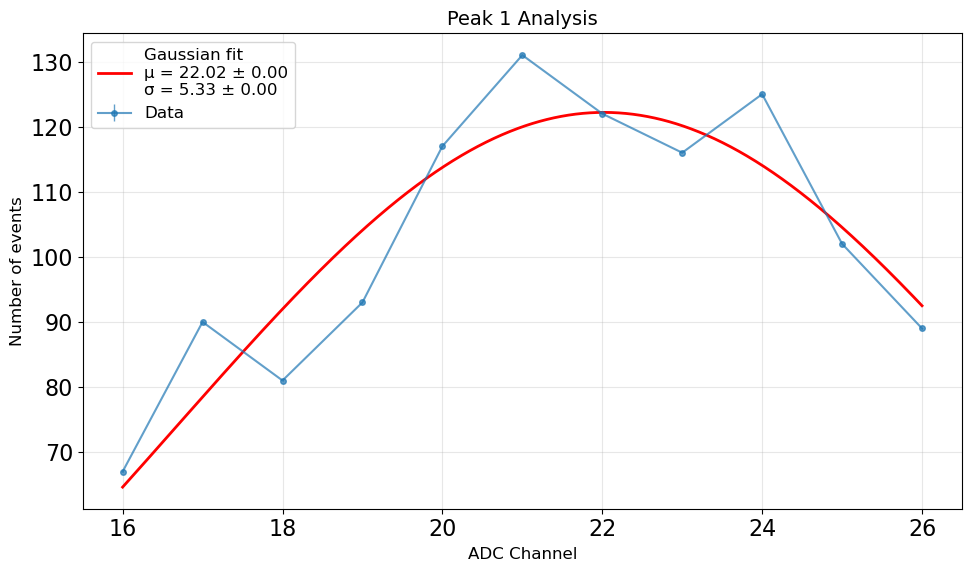


--- Results for Peak 1 Analysis ---
mean: 22.019750041514666
mean_er: 0.0007581530739037625
sigma: 5.332702811748815
sigma_er: 0.0012351437597403674
amplitude: 122.19781561726111
amplitude_er: 0.011620589901644917
energy: unknown
fit_type: gaussian


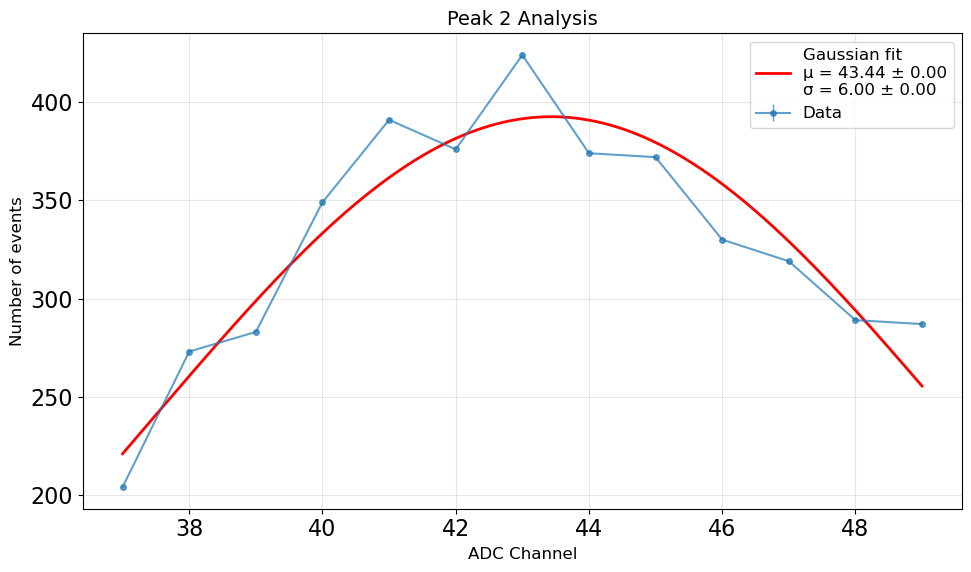


--- Results for Peak 2 Analysis ---
mean: 43.435126031582406
mean_er: 0.00037384348573915577
sigma: 6.002027724749693
sigma_er: 0.0006478852223320445
amplitude: 392.5910889745527
amplitude_er: 0.019500489902967367
energy: unknown
fit_type: gaussian


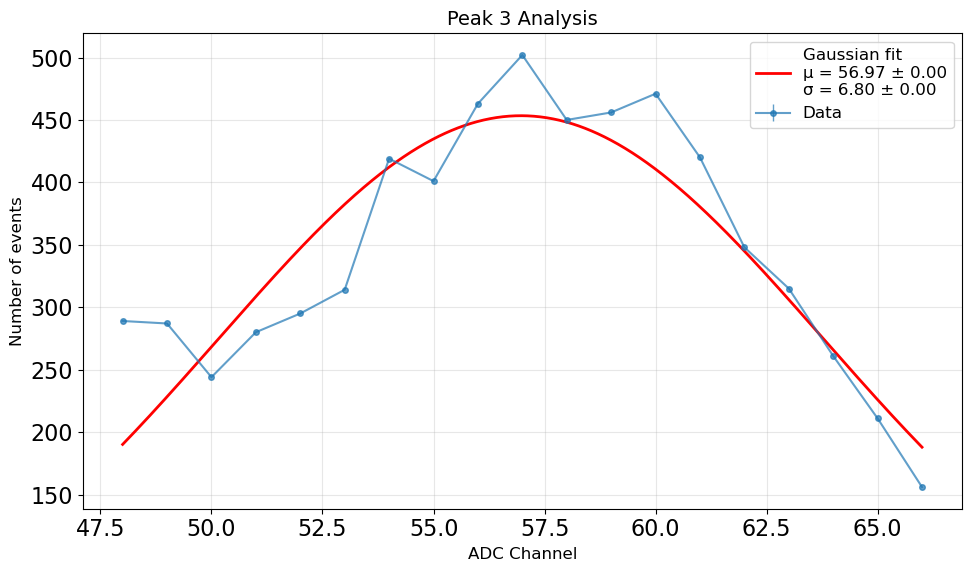


--- Results for Peak 3 Analysis ---
mean: 56.96991656396904
mean_er: 0.00027340304360039816
sigma: 6.804412817575823
sigma_er: 0.0003815612298885962
amplitude: 453.3909872654958
amplitude_er: 0.017977901759511684
energy: unknown
fit_type: gaussian


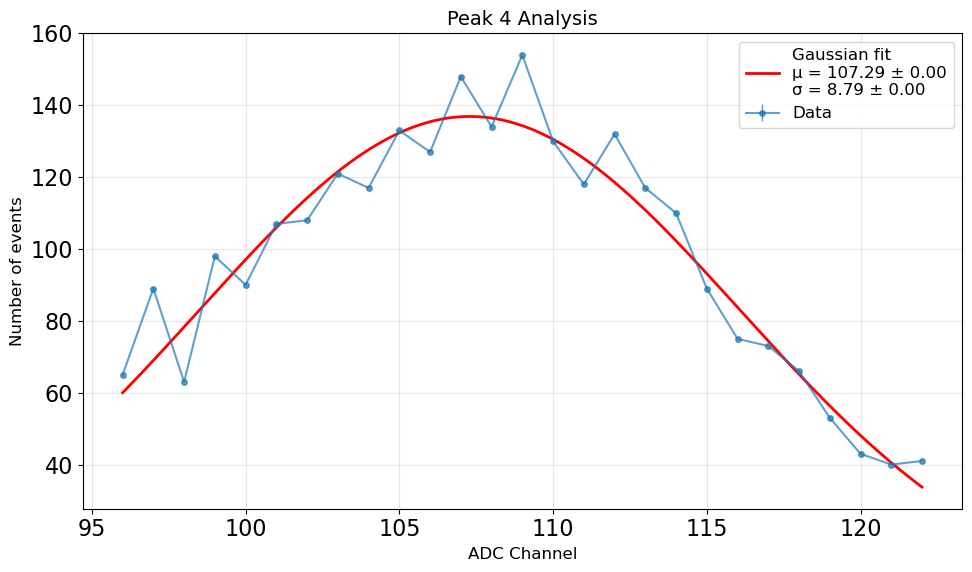


--- Results for Peak 4 Analysis ---
mean: 107.28889217067024
mean_er: 0.0005492003337440758
sigma: 8.78796724655047
sigma_er: 0.0006559691331743849
amplitude: 136.90369157793435
amplitude_er: 0.008284860025475209
energy: unknown
fit_type: gaussian


In [31]:
#Peak analysis
peaks_energies_Ou=[0,0,0,0]
widths = [float(peak_df.FWHM.iloc[0]),float(peak_df.FWHM.iloc[1]),float(peak_df.FWHM.iloc[2]-5),float(peak_df.FWHM.iloc[3])]
meansOu, mean_errsOu, sigmasOu, sigma_errsOu = analyze_spectrum_peaks(
    data=data,
    peakLoc=peakLoc,
    peak_df=peak_df,peaks_energies=peaks_energies_Ou,widths=widths)

In [32]:
print({channel_to_energy(meansOu[i],sigmasOu[i]) for i in range(4)})

26.27 ± 10.25 keV
67.23 ± 11.53 keV
93.11 ± 13.06 keV
189.33 ± 16.87 keV
{None}


## Potatium

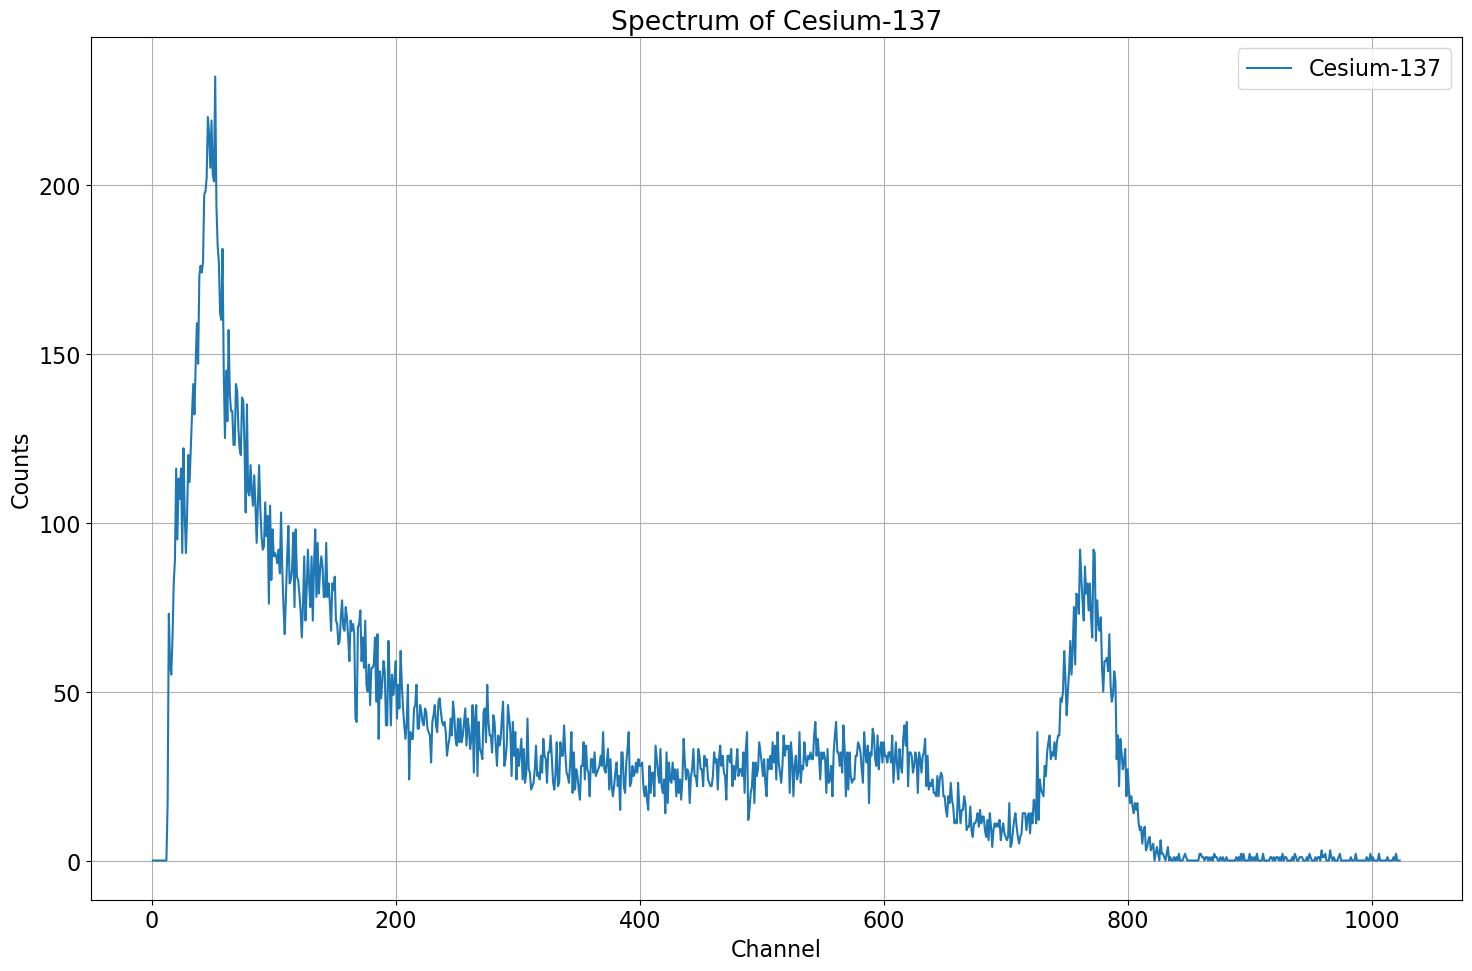

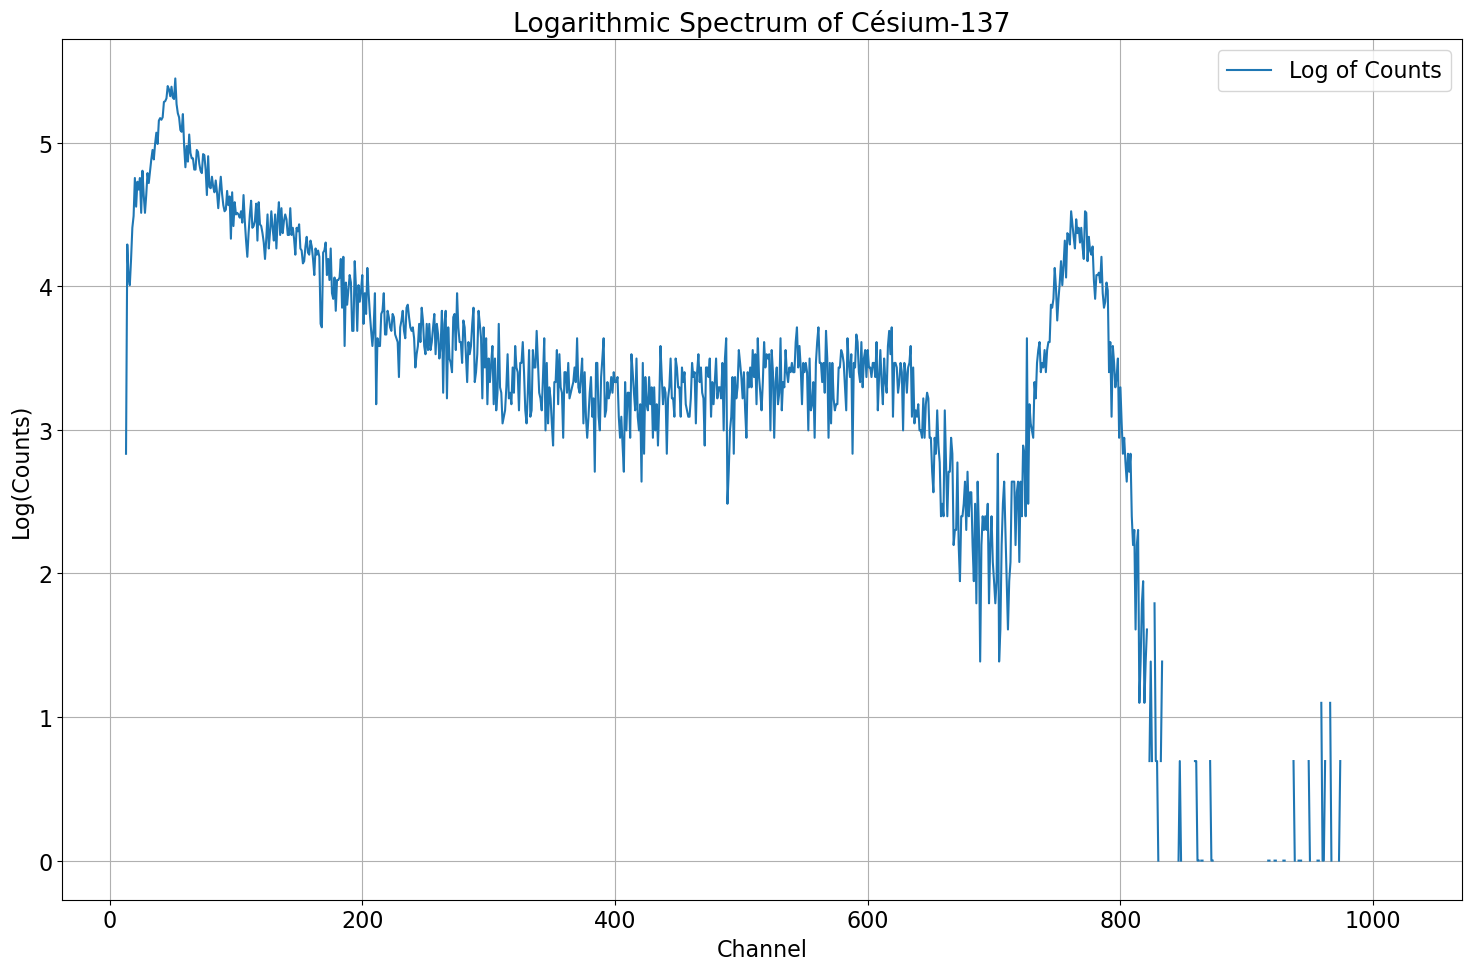

In [70]:
# File path
filename = '/home/dbaconsult/Downloads/PHYSF210/PTM/Detecteur1/Potatium.txt'

# Read the file
fileK = codecs.open(filename, encoding = "ISO-8859-1")
data = read_file(fileK)

# Plot: raw data
plt.figure()
plt.plot(data['channel'], data['N'], label="Cesium-137")
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.title("Spectrum of Cesium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: log-transformed data
plt.figure()
plt.plot(data['channel'], np.log(data['N'].replace(0, np.nan)), label="Log of Counts")  # Avoid log(0)
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Log(Counts)")
plt.title("Logarithmic Spectrum of Césium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

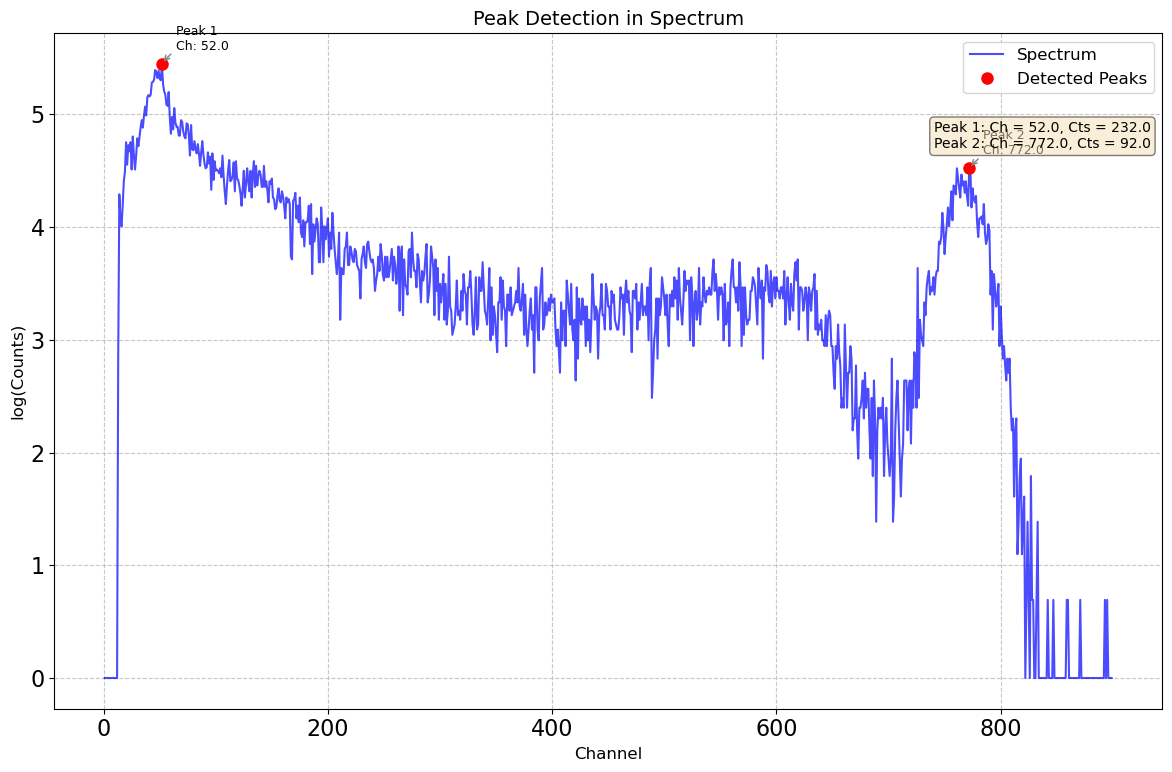

Detected Peaks:
   Peak_Number  Channel  Counts        FWHM  Prominence
0            1     52.0   232.0  371.008783    5.446737
1            2    772.0    92.0   67.957843    3.135494


In [71]:
# Peak locations
peak_df =  detect_peaks(data, max_channel=900, min_height=4, min_distance=15, min_prominence=3, min_width=5, plot=True, use_log=True)
peakLoc= peak_df['Channel']

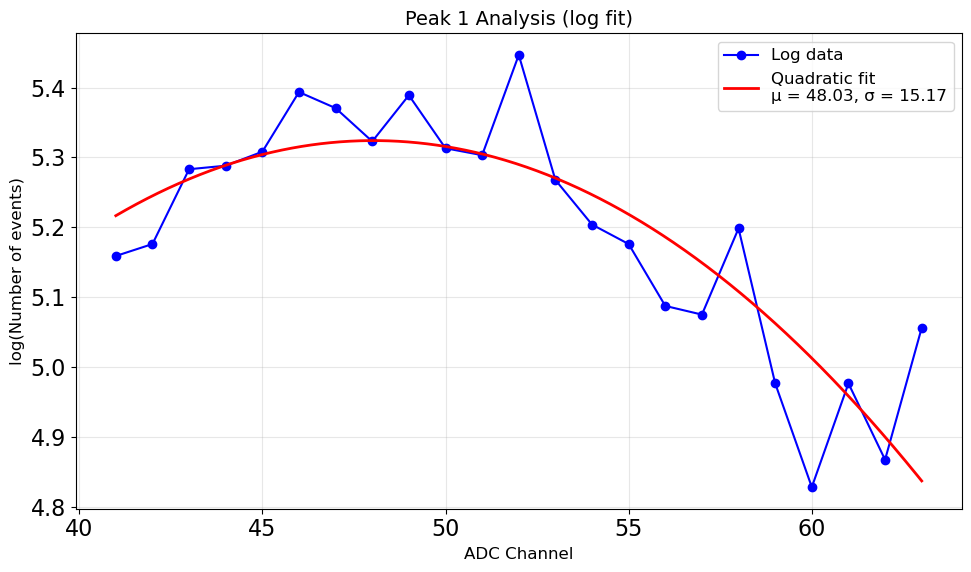


--- Results for Peak 1 Analysis ---
mean: 48.03192284838708
mean_er: nan
sigma: 15.166410323933217
sigma_er: nan
a: -0.0021737240040211603
b: 0.20881628730966284
c: 0.30926759117419833
energy: unknown
fit_type: log-parabola


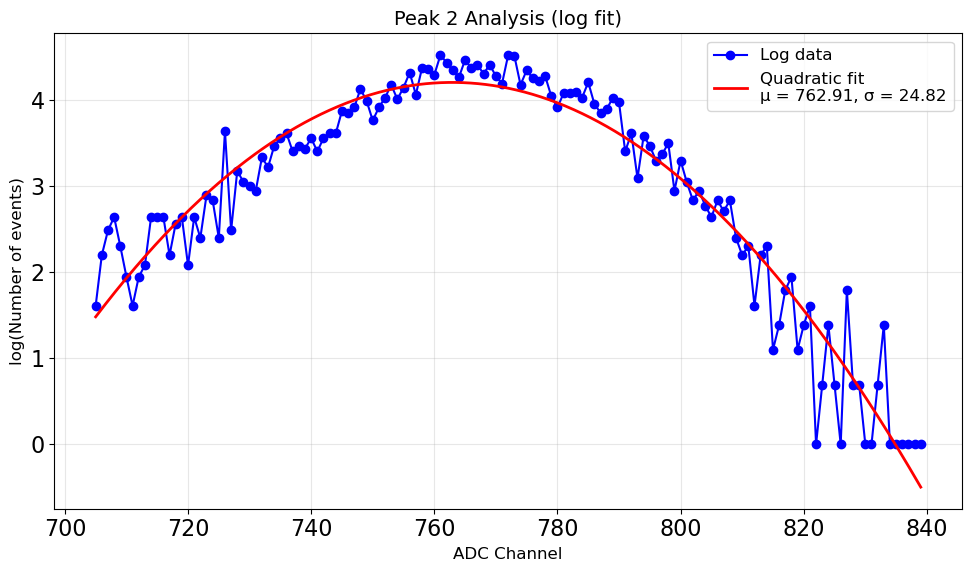


--- Results for Peak 2 Analysis ---
mean: 762.9096588216439
mean_er: nan
sigma: 24.822838016328593
sigma_er: nan
a: -0.0008114600395683347
b: 1.2381414038689518
c: -468.0922752383504
energy: unknown
fit_type: log-parabola


In [72]:
#Peak analysis
peaks_energies_K=[0,0]
widths = [float(peak_df.FWHM.iloc[0]-360),float(peak_df.FWHM.iloc[1])]
meansK, mean_errsK, sigmasK, sigma_errsK = analyze_spectrum_peaks(
    data=data,
    peakLoc=peakLoc,
    peak_df=peak_df,peaks_energies=peaks_energies_K, widths=widths, use_log=True)

In [73]:
print({channel_to_energy(meansK[i],sigmasK[i]) for i in range(2)})

76.02 ± 29.02 keV
1443.09 ± 47.98 keV
{None}


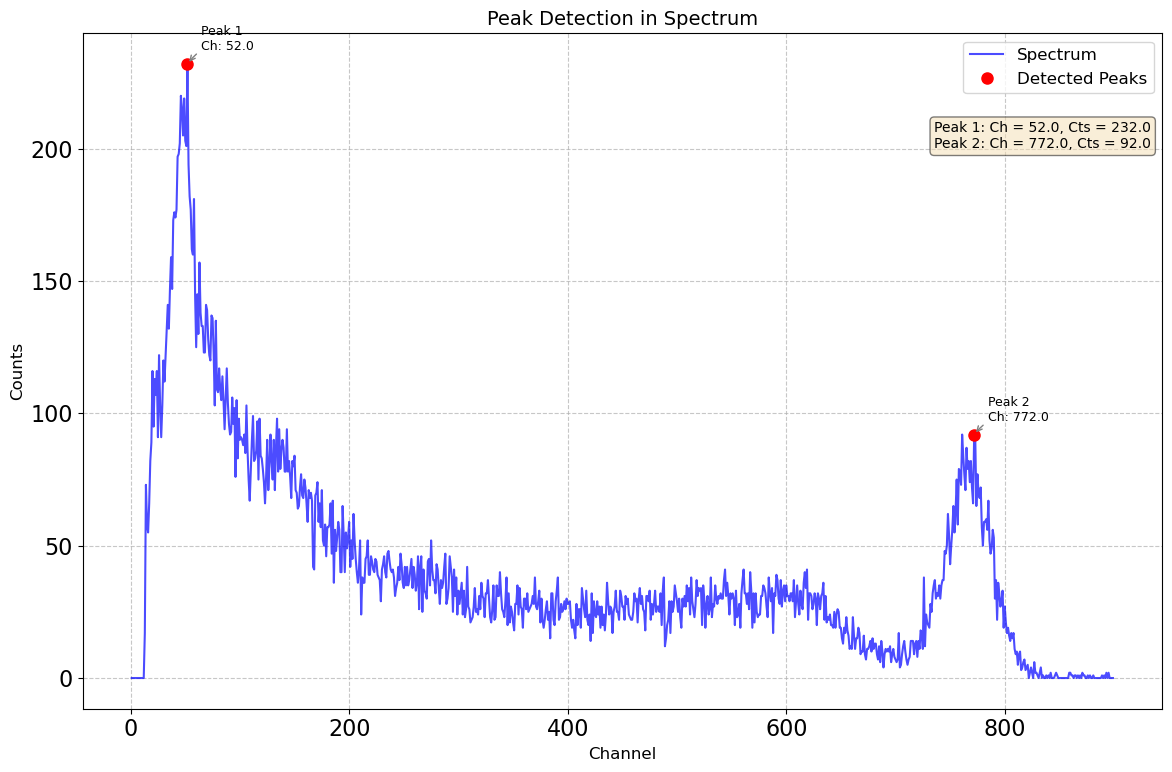

Detected Peaks:
   Peak_Number  Channel  Counts       FWHM  Prominence
0            1     52.0   232.0  44.950000       232.0
1            2    772.0    92.0  36.085714        88.0


In [74]:
# Peak locations
peak_df =  detect_peaks(data, max_channel=900, min_height=30, min_distance=15, min_prominence=40, min_width=5, plot=True, use_log=False)
peakLoc= peak_df['Channel']

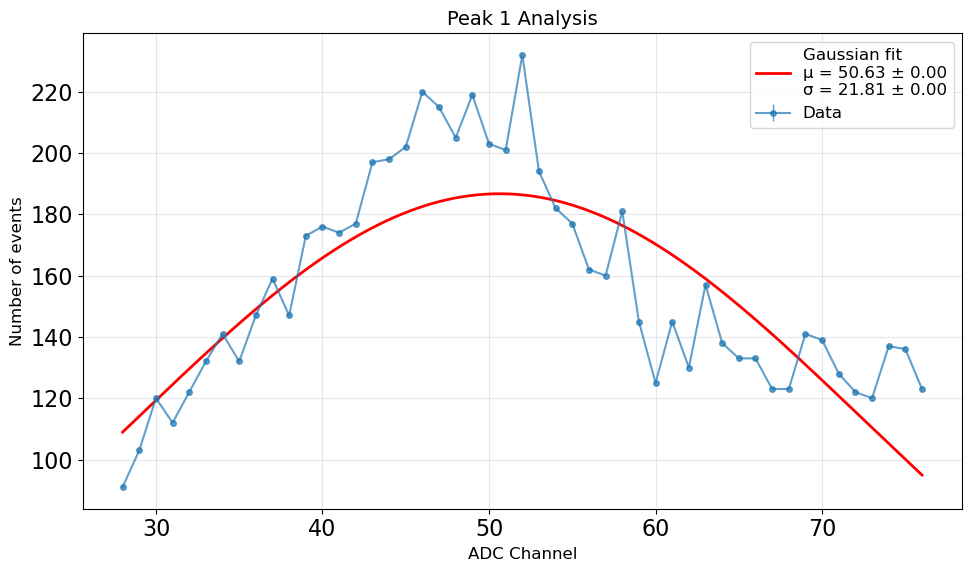


--- Results for Peak 1 Analysis ---
mean: 50.634695616089324
mean_er: 0.0004158926011930681
sigma: 21.805459158635188
sigma_er: 0.0007202377019643141
amplitude: 186.7201275264558
amplitude_er: 0.0030394927119468686
energy: unknown
fit_type: gaussian


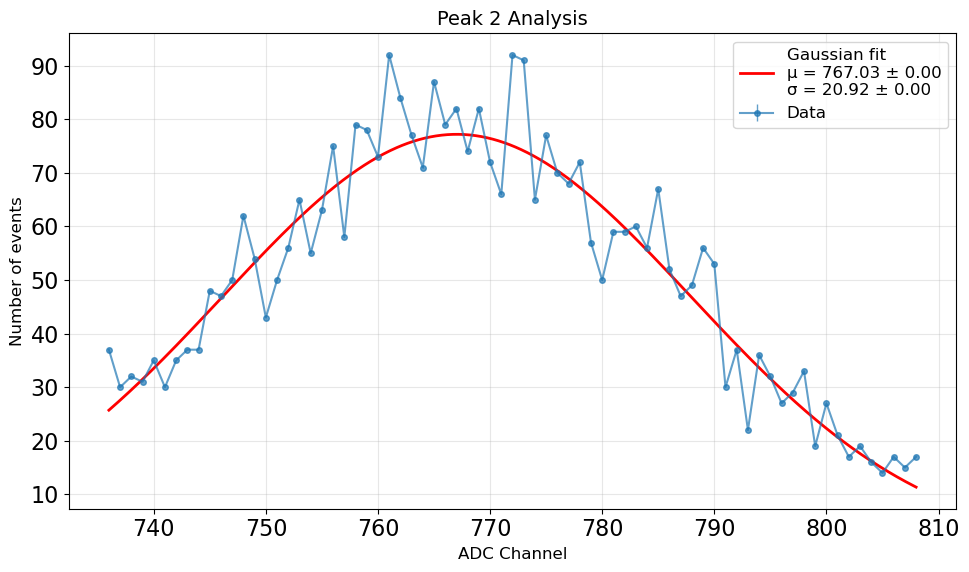


--- Results for Peak 2 Analysis ---
mean: 767.0284194362338
mean_er: 0.0004355487366200732
sigma: 20.92424850524418
sigma_er: 0.00046879446481484257
amplitude: 77.19582486664534
amplitude_er: 0.0016772994203854321
energy: unknown
fit_type: gaussian


In [75]:
#Peak analysis
peaks_energies_K=[0,0]
widths = [float(peak_df.FWHM.iloc[0])-20,float(peak_df.FWHM.iloc[1])]
meansK, mean_errsK, sigmasK, sigma_errsK = analyze_spectrum_peaks(
    data=data,
    peakLoc=peakLoc,
    peak_df=peak_df,peaks_energies=peaks_energies_K, widths=widths, use_log=False)

In [76]:
print({channel_to_energy(meansK[i],sigmasK[i]) for i in range(2)})

80.99 ± 41.71 keV
1450.96 ± 40.62 keV
{None}


## Medaillon



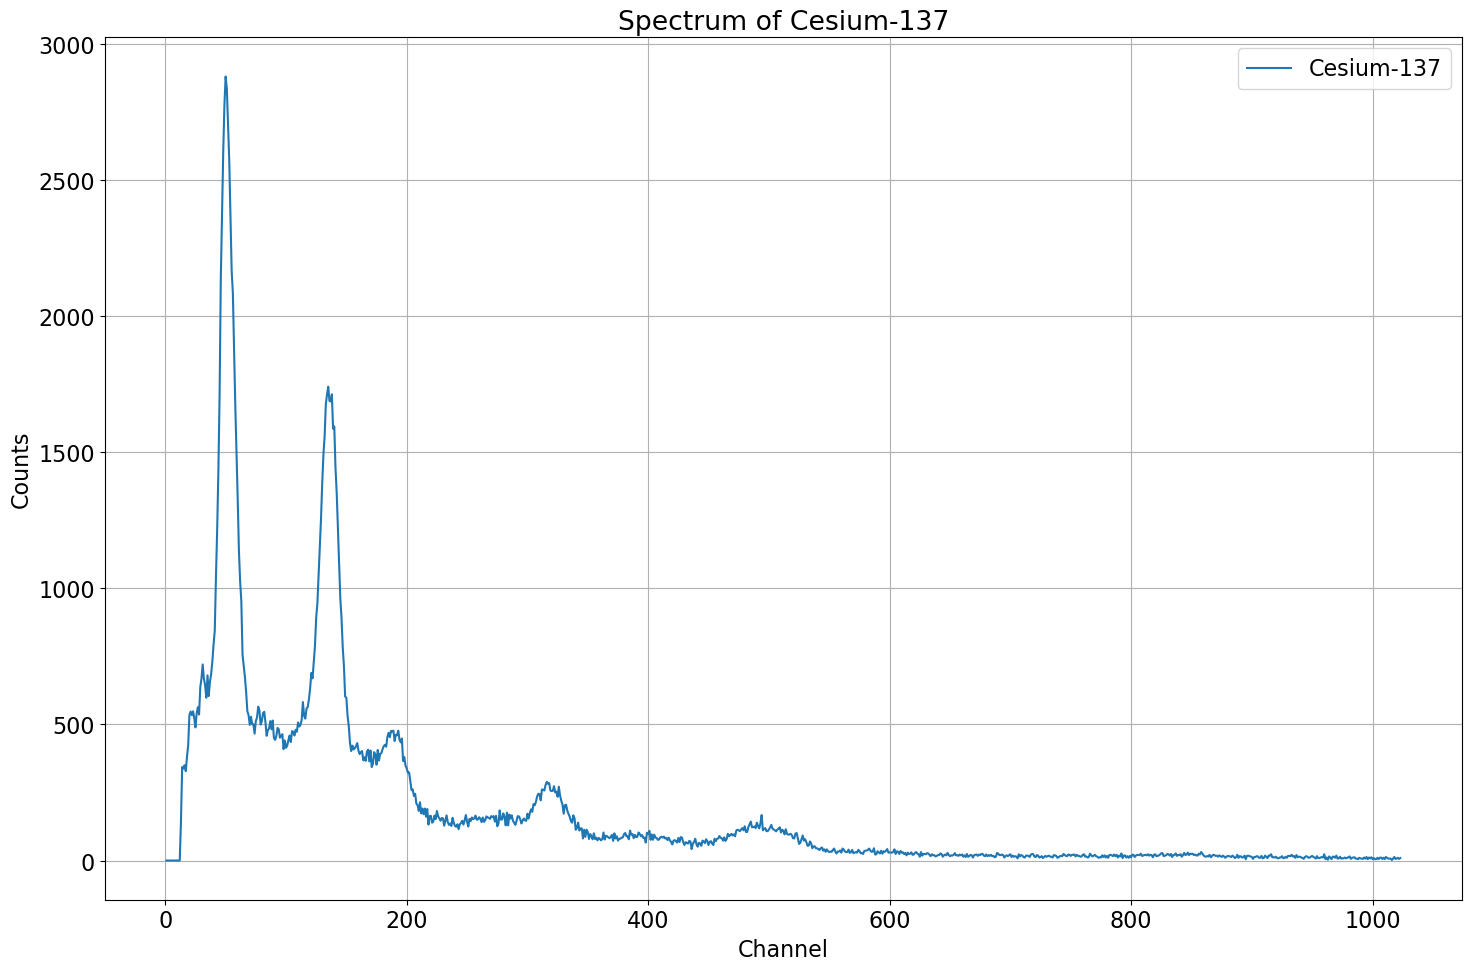

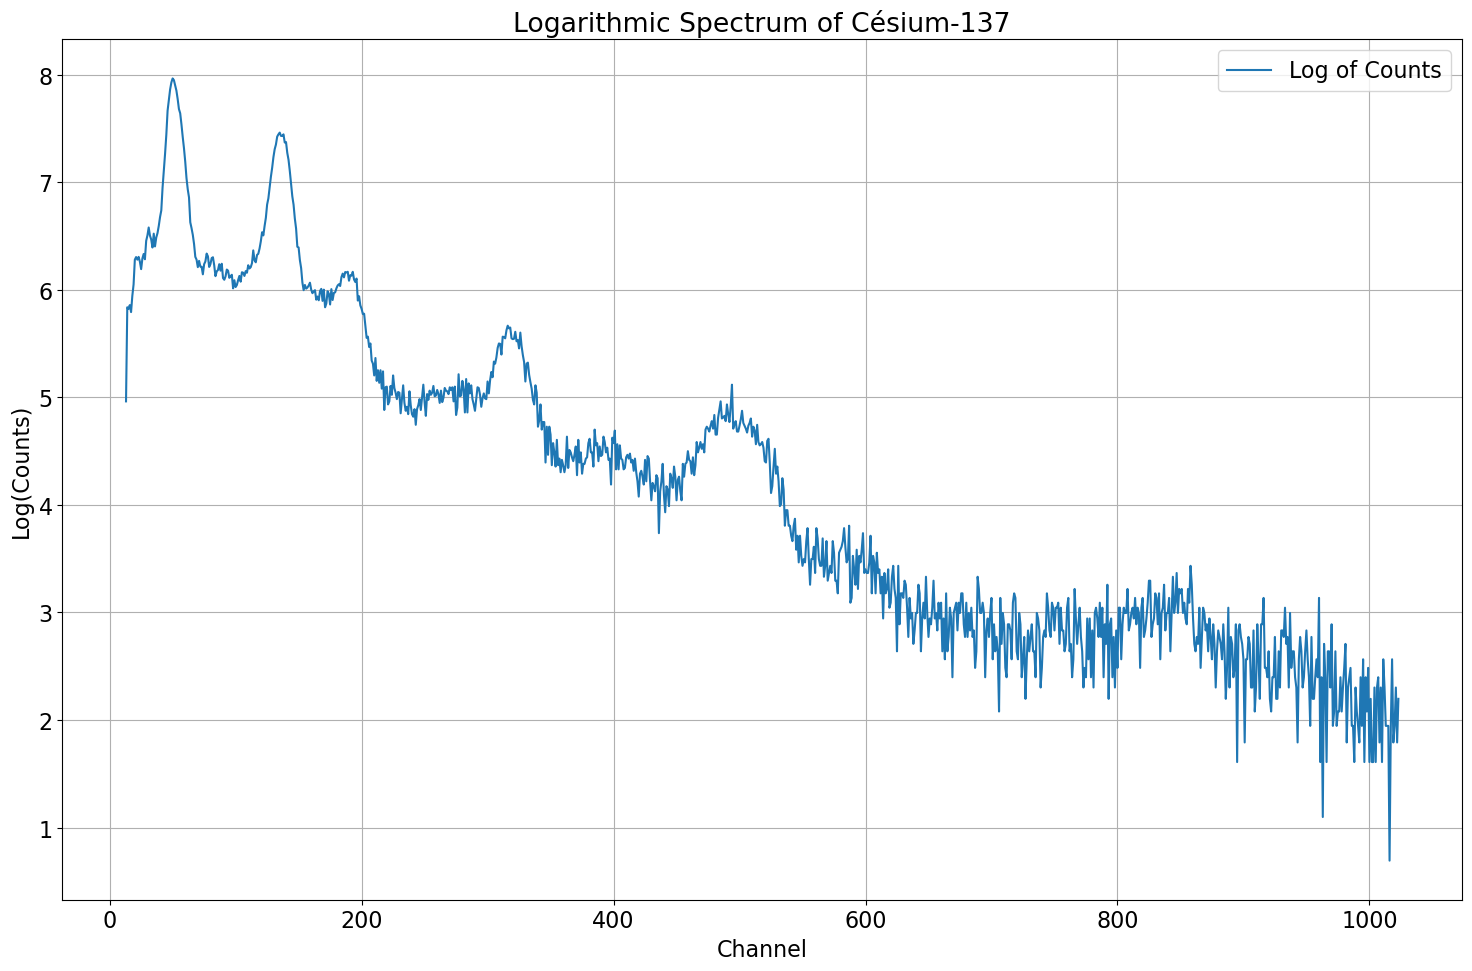

In [37]:
# File path
filename = '/home/dbaconsult/Downloads/PHYSF210/PTM/Detecteur1/Medaillon.txt'

# Read the file
fileMed = codecs.open(filename, encoding = "ISO-8859-1")
data = read_file(fileMed)

# Plot: raw data
plt.figure()
plt.plot(data['channel'], data['N'], label="Cesium-137")
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.title("Spectrum of Cesium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: log-transformed data
plt.figure()
plt.plot(data['channel'], np.log(data['N'].replace(0, np.nan)), label="Log of Counts")  # Avoid log(0)
plt.legend()
plt.xlabel("Channel")
plt.ylabel("Log(Counts)")
plt.title("Logarithmic Spectrum of Césium-137")
plt.grid(True)
plt.tight_layout()
plt.show()

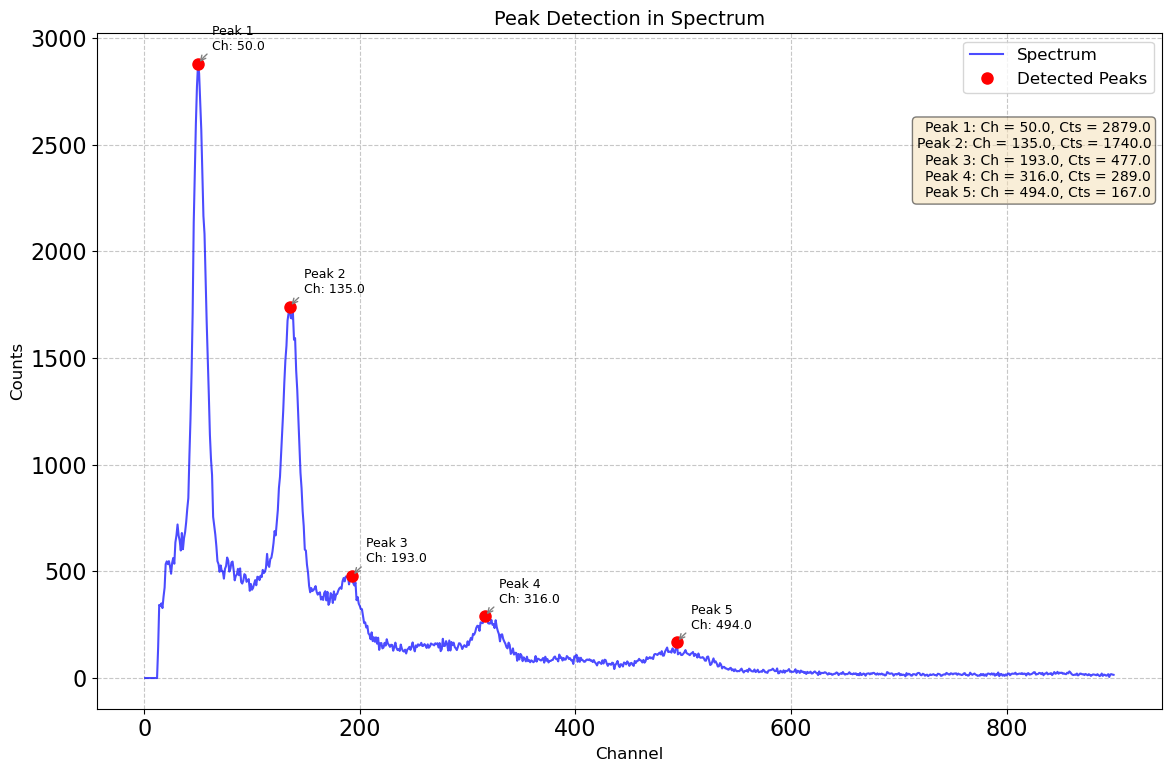

Detected Peaks:
   Peak_Number  Channel  Counts       FWHM  Prominence
0            1     50.0  2879.0  15.316364      2874.0
1            2    135.0  1740.0  16.751097      1331.0
2            3    193.0   477.0  16.366922       134.0
3            4    316.0   289.0  24.296218       174.0
4            5    494.0   167.0  37.182957       125.0


In [38]:
# Peak locations
peak_df =  detect_peaks(data, max_channel=900, min_height=50, min_distance=15, min_prominence=50, min_width=5, plot=True)
peakLoc= peak_df['Channel']

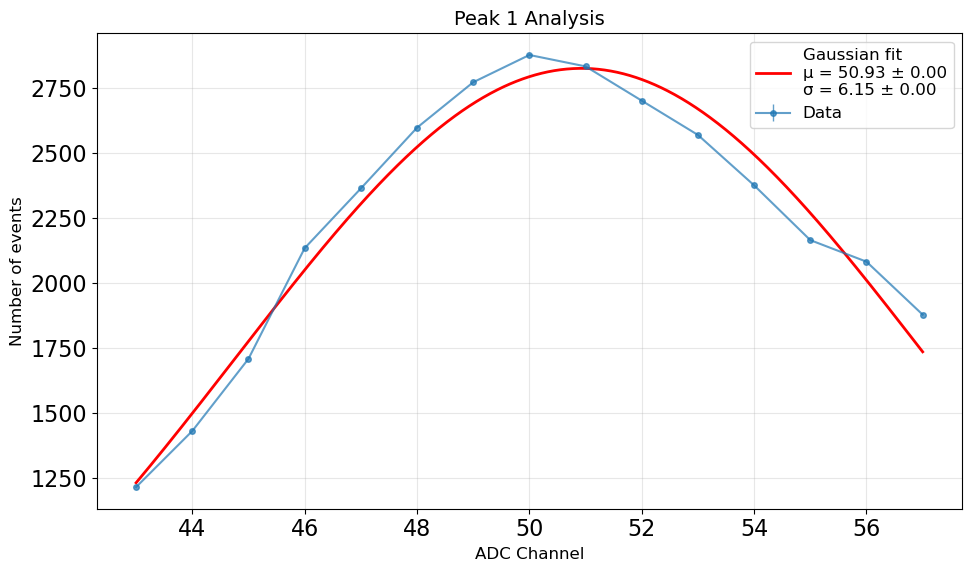


--- Results for Peak 1 Analysis ---
mean: 50.92670653823986
mean_er: 0.000146351449402975
sigma: 6.148542204843606
sigma_er: 0.00021437127511013992
amplitude: 2827.408717228603
amplitude_er: 0.055243731347011604
energy: unknown
fit_type: gaussian


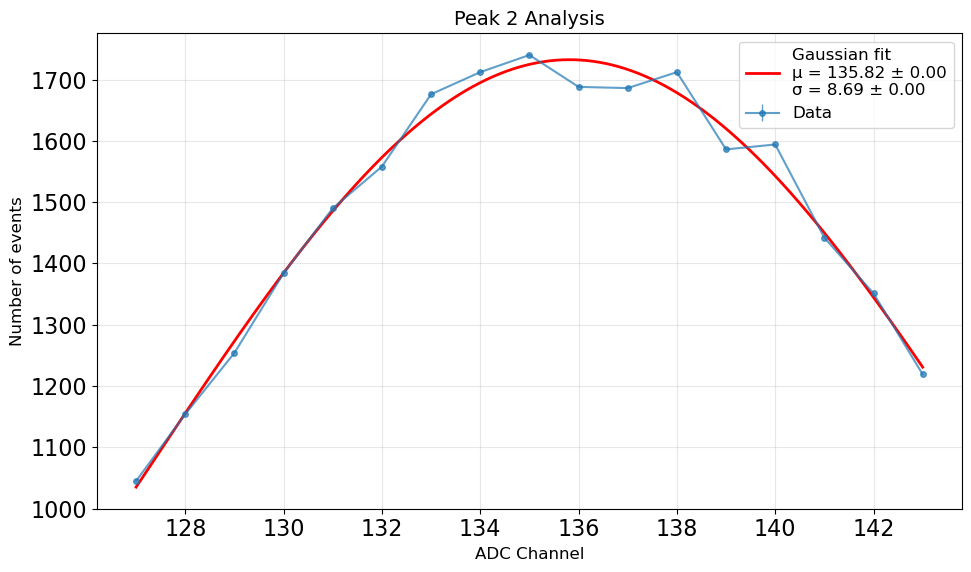


--- Results for Peak 2 Analysis ---
mean: 135.81708238760382
mean_er: 0.0002783502944355777
sigma: 8.686893775353706
sigma_er: 0.000520341413742553
amplitude: 1732.3531687866025
amplitude_er: 0.03994965223074579
energy: unknown
fit_type: gaussian


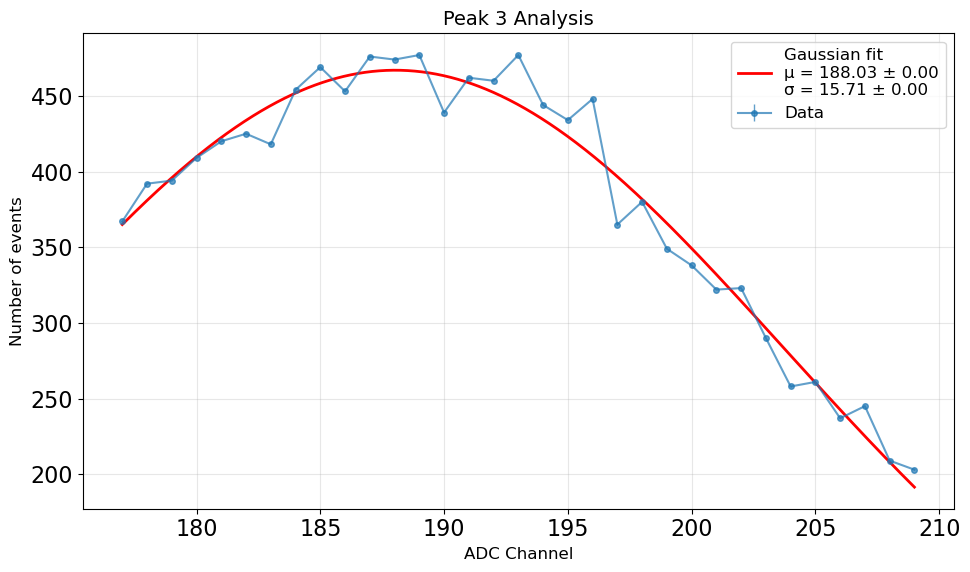


--- Results for Peak 3 Analysis ---
mean: 188.02677773737383
mean_er: 0.0009029674424330526
sigma: 15.707601679277817
sigma_er: 0.0011825358066723122
amplitude: 466.963109192126
amplitude_er: 0.014288352555948933
energy: unknown
fit_type: gaussian


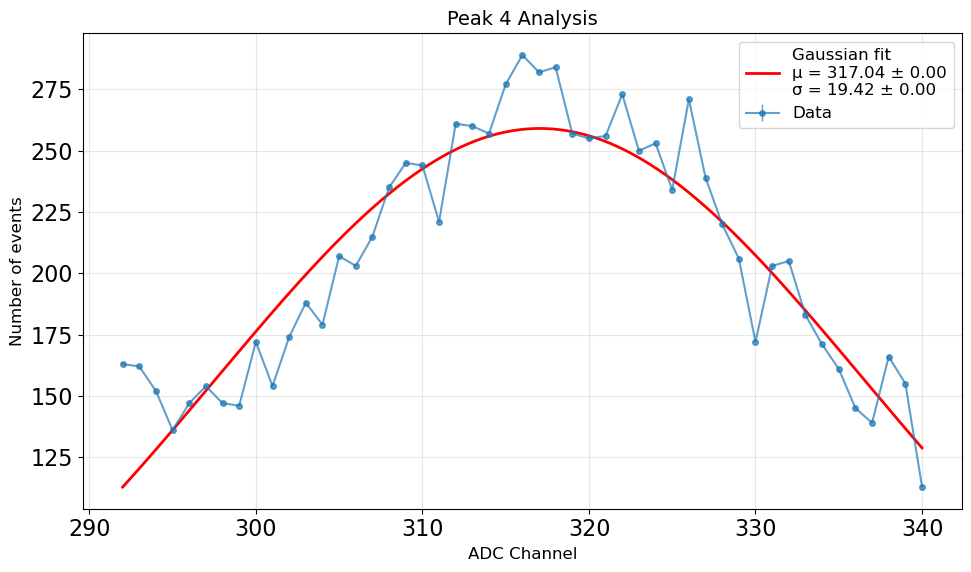


--- Results for Peak 4 Analysis ---
mean: 317.0416069341175
mean_er: 0.0007655133342149131
sigma: 19.41880505882689
sigma_er: 0.001183092022158184
amplitude: 259.061044622622
amplitude_er: 0.009461471603775981
energy: unknown
fit_type: gaussian


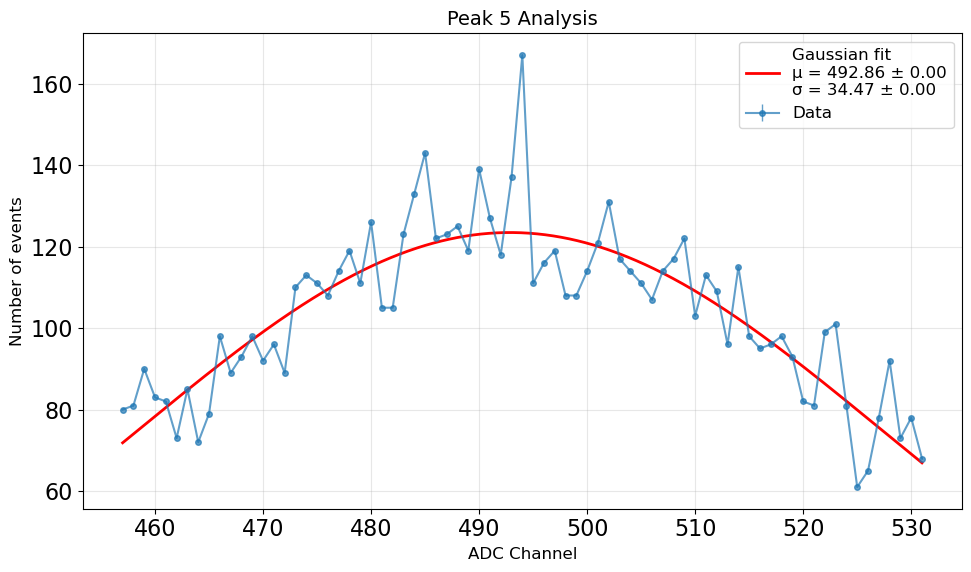


--- Results for Peak 5 Analysis ---
mean: 492.8609282170947
mean_er: 0.001744684962615285
sigma: 34.46736873424818
sigma_er: 0.0030743890044860537
amplitude: 123.45413800236236
amplitude_er: 0.005161726897304315
energy: unknown
fit_type: gaussian


In [39]:
#Peak analysis
peaks_energies_Med=[0,0,0,0,0]
widths = [float(peak_df.FWHM.iloc[0]-8),float(peak_df.FWHM.iloc[1]-8),float(peak_df.FWHM.iloc[2]),float(peak_df.FWHM.iloc[3]),float(peak_df.FWHM.iloc[4])]
meansMed, mean_errsMed, sigmasMed, sigma_errsMed = analyze_spectrum_peaks(
    data=data,
    peakLoc=peakLoc,
    peak_df=peak_df,peaks_energies=peaks_energies_Med,widths=widths)

In [40]:
print({channel_to_energy(meansMed[i],sigmasMed[i]) for i in range(5)})

81.55 ± 11.81 keV
243.89 ± 16.69 keV
343.73 ± 30.10 keV
590.45 ± 37.26 keV
926.67 ± 66.07 keV
{None}
